# Search For Oscillation Frequencies <a class="anchor" id="section1"></a>

Import Libraries and Configuration Parameters

In [9]:
import statistics
import astropy
from astropy.timeseries import LombScargle, BoxLeastSquares
from scipy import interpolate, signal
from scipy.signal import medfilt

import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
import exoplanet as xo
from celerite2.theano import terms, GaussianProcess

import transitleastsquares as tls
import lightkurve as lk

AttributeError: module 'arviz' has no attribute 'geweke'

In [10]:
%matplotlib inline
%run notebook_setup

RuntimeError: context has already been set

## Download and Prepare the Data

Note: Make sure the EB catalog from the Villanova Database is in the same folder as this Jupyter notebook.

In [11]:
kepler_tref = 2454833
villanova_tref = 2400000

def get_true_eb_values(name, df):
    idx_target = np.where(catalog["#KIC"] == name)[0][0]

    #Period and t0
    P = df.loc[idx_target, 'period']
    t0 = df.loc[
        idx_target,
        'bjd0'] + villanova_tref - kepler_tref  # Time of eclipse. Convention s.t. the primary (deeper) eclipse occurs at phase 0 (BJD-2400000)'

    ### In case they become useful in the future:
    R1 = df.loc[idx_target, 'radius']
    M1 = df.loc[idx_target, 'mass']
    teff = df.loc[idx_target, 'teff']
    logg = df.loc[idx_target, 'logg']
    feh = df.loc[idx_target, 'feh']
    morph = df.loc[idx_target, 'morph']

    print(M1)
    
    #Light curve parameters
    pdepth = df.loc[idx_target, 'pdepth']  #in flux units
    sdepth = df.loc[idx_target, 'sdepth']  #in flux units
    pwidth = 2 * df.loc[
        idx_target,
        'pwidth']  #in Phase units (it seems to be 1/2 the eclipse duration, so that's why we multiply it by 2)
    swidth = 2 * df.loc[idx_target, 'swidth']

    return P, t0, pwidth, swidth

In [12]:
def load_lc(name, flux_type, upper_sigma, plot_bool):
    data = lk.search_lightcurvefile('KIC%s' % name,
                                    cadence=cadence_type,
                                    mission='kepler').download_all()
    print(data)

    if flux_type == "SAP":
        lc_data = data.SAP_FLUX.stitch().remove_nans().remove_outliers(
            sigma=upper_sigma, sigma_lower=float('inf'))
    else:
        lc_data = data.PDCSAP_FLUX.stitch().remove_nans().remove_outliers(
            sigma=upper_sigma, sigma_lower=float('inf'))

        
    #Lightkurve lightcurves are not necessarily sorted in time, which 
    # causes an error in periodogram: Source. https://github.com/grd349/PBjam/blob/d7709d2db0a9145d7028047dbde2ac2a4a5795b3/pbjam/session.py
    sidx = np.argsort(lc_data.time)
    lc_data.time = lc_data.time[sidx]
    lc_data.flux = lc_data.flux[sidx]

    if plot_bool == True:
        fig, ax = plt.subplots(1, 1)
        lc_data.scatter(ax=ax, label=None, s=1)
        ax.set_xlabel(xlabel="Time - %i [BKJD days]" % kepler_tref, size=25)
        ax.set_ylabel("Normalized Flux", size=25)
        ax.set_title(r"KIC%s $\it{Kepler}$ Light Curve" % KIC,
                     fontsize=30,
                     y=1.03)

    return lc_data, data

In [13]:
KIC = 12071006#4544587
flux_type = "SAP"  #or PDCSAP
cadence_type = "short"  #input("Cadence Type [short/long]: ")
upper_sigma = 3.0  #float(input("Upper sigma: "))
kepler_lc, lcfs = load_lc(KIC, flux_type, upper_sigma, plot_bool=True)
print("Number of Measurements:", len(kepler_lc.time))
if not os.path.exists("KIC%s/" % KIC): os.makedirs("KIC%s/" % KIC)

NameError: name 'lk' is not defined

In [6]:
if list(kepler_lc.time) == sorted(list(kepler_lc.time)):
    print("Time array is sorted.")

Time array is sorted.


## Select Segment

Number of segments:  13


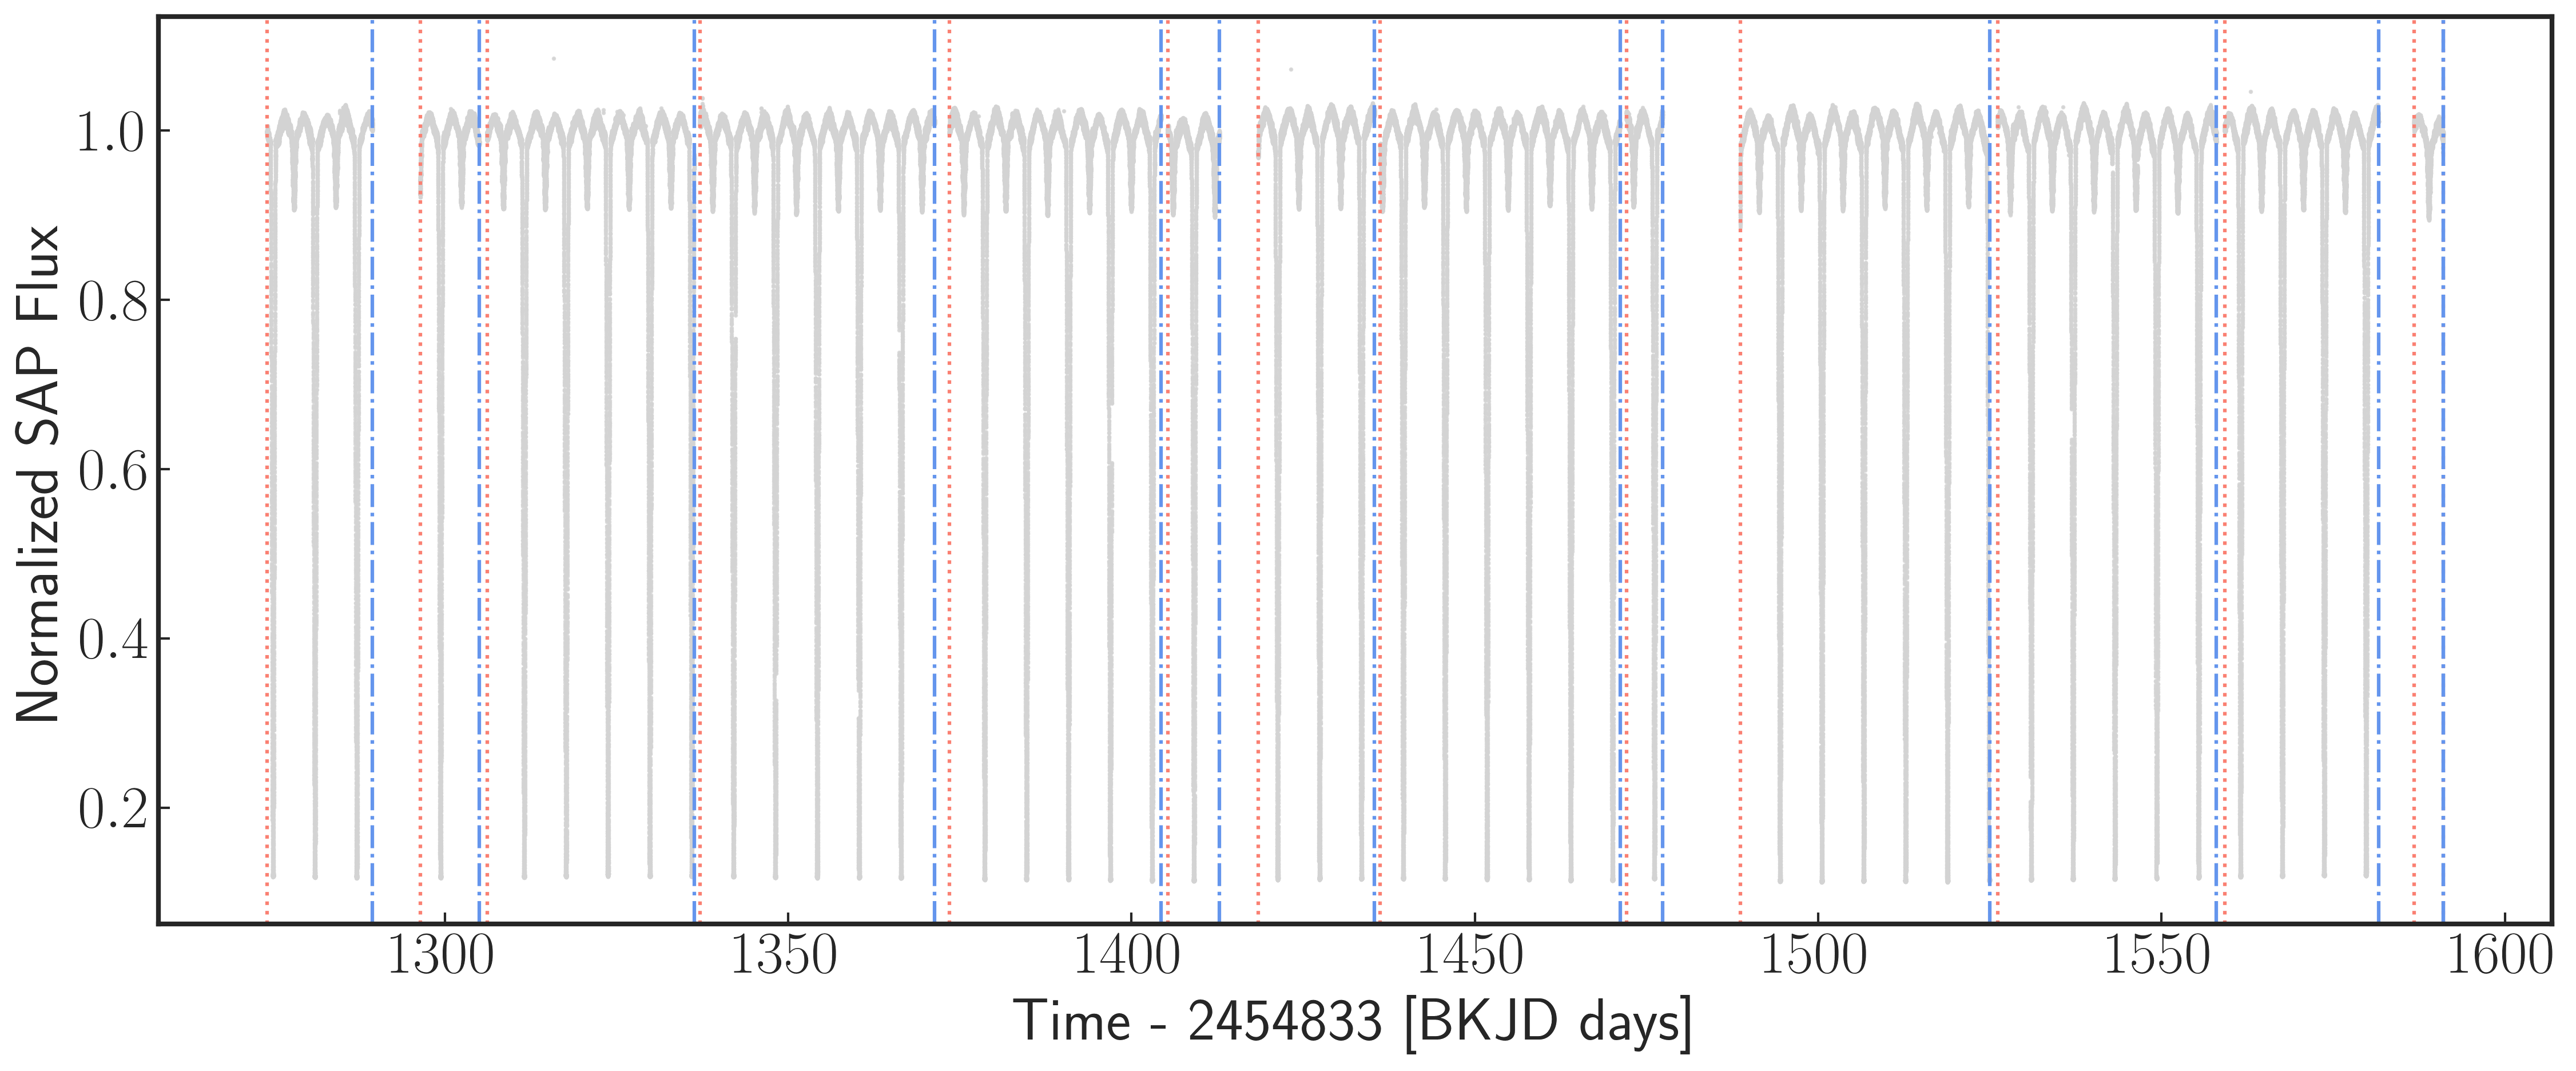

In [7]:
def get_gaps_indexes(time, flux, break_tolerance, plot_bool):
    #Adapted from Wotan (https://github.com/hippke/wotan/blob/382f5bfd73f8ca31522af0e4fa64cd4813441886/wotan/gaps.py)
    """Array indexes where ``time`` has gaps longer than ``break_tolerance``"""
    gaps = np.diff(time)
    gaps_indexes = np.where(gaps > break_tolerance)
    gaps_indexes = np.add(gaps_indexes, 1)  # Off by one :-)
    gaps_indexes = np.concatenate(gaps_indexes).ravel()  # Flatten
    gaps_indexes = np.append(np.array([0]), gaps_indexes)  # Start
    gaps_indexes = np.append(gaps_indexes,
                             np.array([len(time) + 1]))  # End point

    num_gaps = len(gaps_indexes)
    gaps_end = gaps_indexes - 1
    gaps_end[num_gaps - 1] -= 1
    gaps_indexes[num_gaps - 1] -= 2

    if plot_bool == True:
        fig, ax = plt.subplots(1, 1, figsize=(18, 7))
        ax.scatter(time, flux, c="lightgrey", s=1, alpha=0.8)
        ax.set_xlabel(xlabel="Time - %i [BKJD days]" % kepler_tref, size=25)
        ax.set_ylabel("Normalized %s Flux" %flux_type, size=25)
        for i in gaps_indexes:
            ax.axvline(time[i], color="salmon", lw=1.5, ls=":")
        for e in gaps_end:
            ax.axvline(time[e], color="cornflowerblue", lw=1.5, ls="-.")

    return gaps_indexes, gaps_end, num_gaps


threshold = 0.5  #float(input("Threshold tolerance [d] : ")) #float(input("Enter threshold tolerance [d]:"))
init_gaps, end_gaps, ngaps = get_gaps_indexes(kepler_lc.time,
                                              kepler_lc.flux,
                                              threshold,
                                              plot_bool=True)
print("Number of segments: ", ngaps - 1)


### Choose Segment to work on

In [8]:
init_chunk, end_chunk = init_gaps[0], end_gaps[1]
lc_mask = (kepler_lc.time >= kepler_lc.time[init_chunk]) & (kepler_lc.time <= kepler_lc.time[end_chunk])

print("We'll study the segment comprised between points %i and points %i" %(init_chunk, end_chunk))

We'll study the segment comprised between points 0 and points 22222


Create Folders to store the Results of the Analysis

In [9]:
chunk_name = str(init_chunk) + "_" + str(end_chunk) + "/"
fpath = "KIC%s/" % KIC
arr = os.listdir(fpath)
folders = ["data", "diagnostics", "tfreq_analysis", "map", "wavelets"]

if not os.path.exists(fpath + chunk_name): os.makedirs(fpath + chunk_name)
else: print("The folder for this segment already exists!")

for f in folders:
    if not os.path.exists(fpath + chunk_name + f):
        os.makedirs(fpath + chunk_name + f)

fpath_chunk = fpath + chunk_name

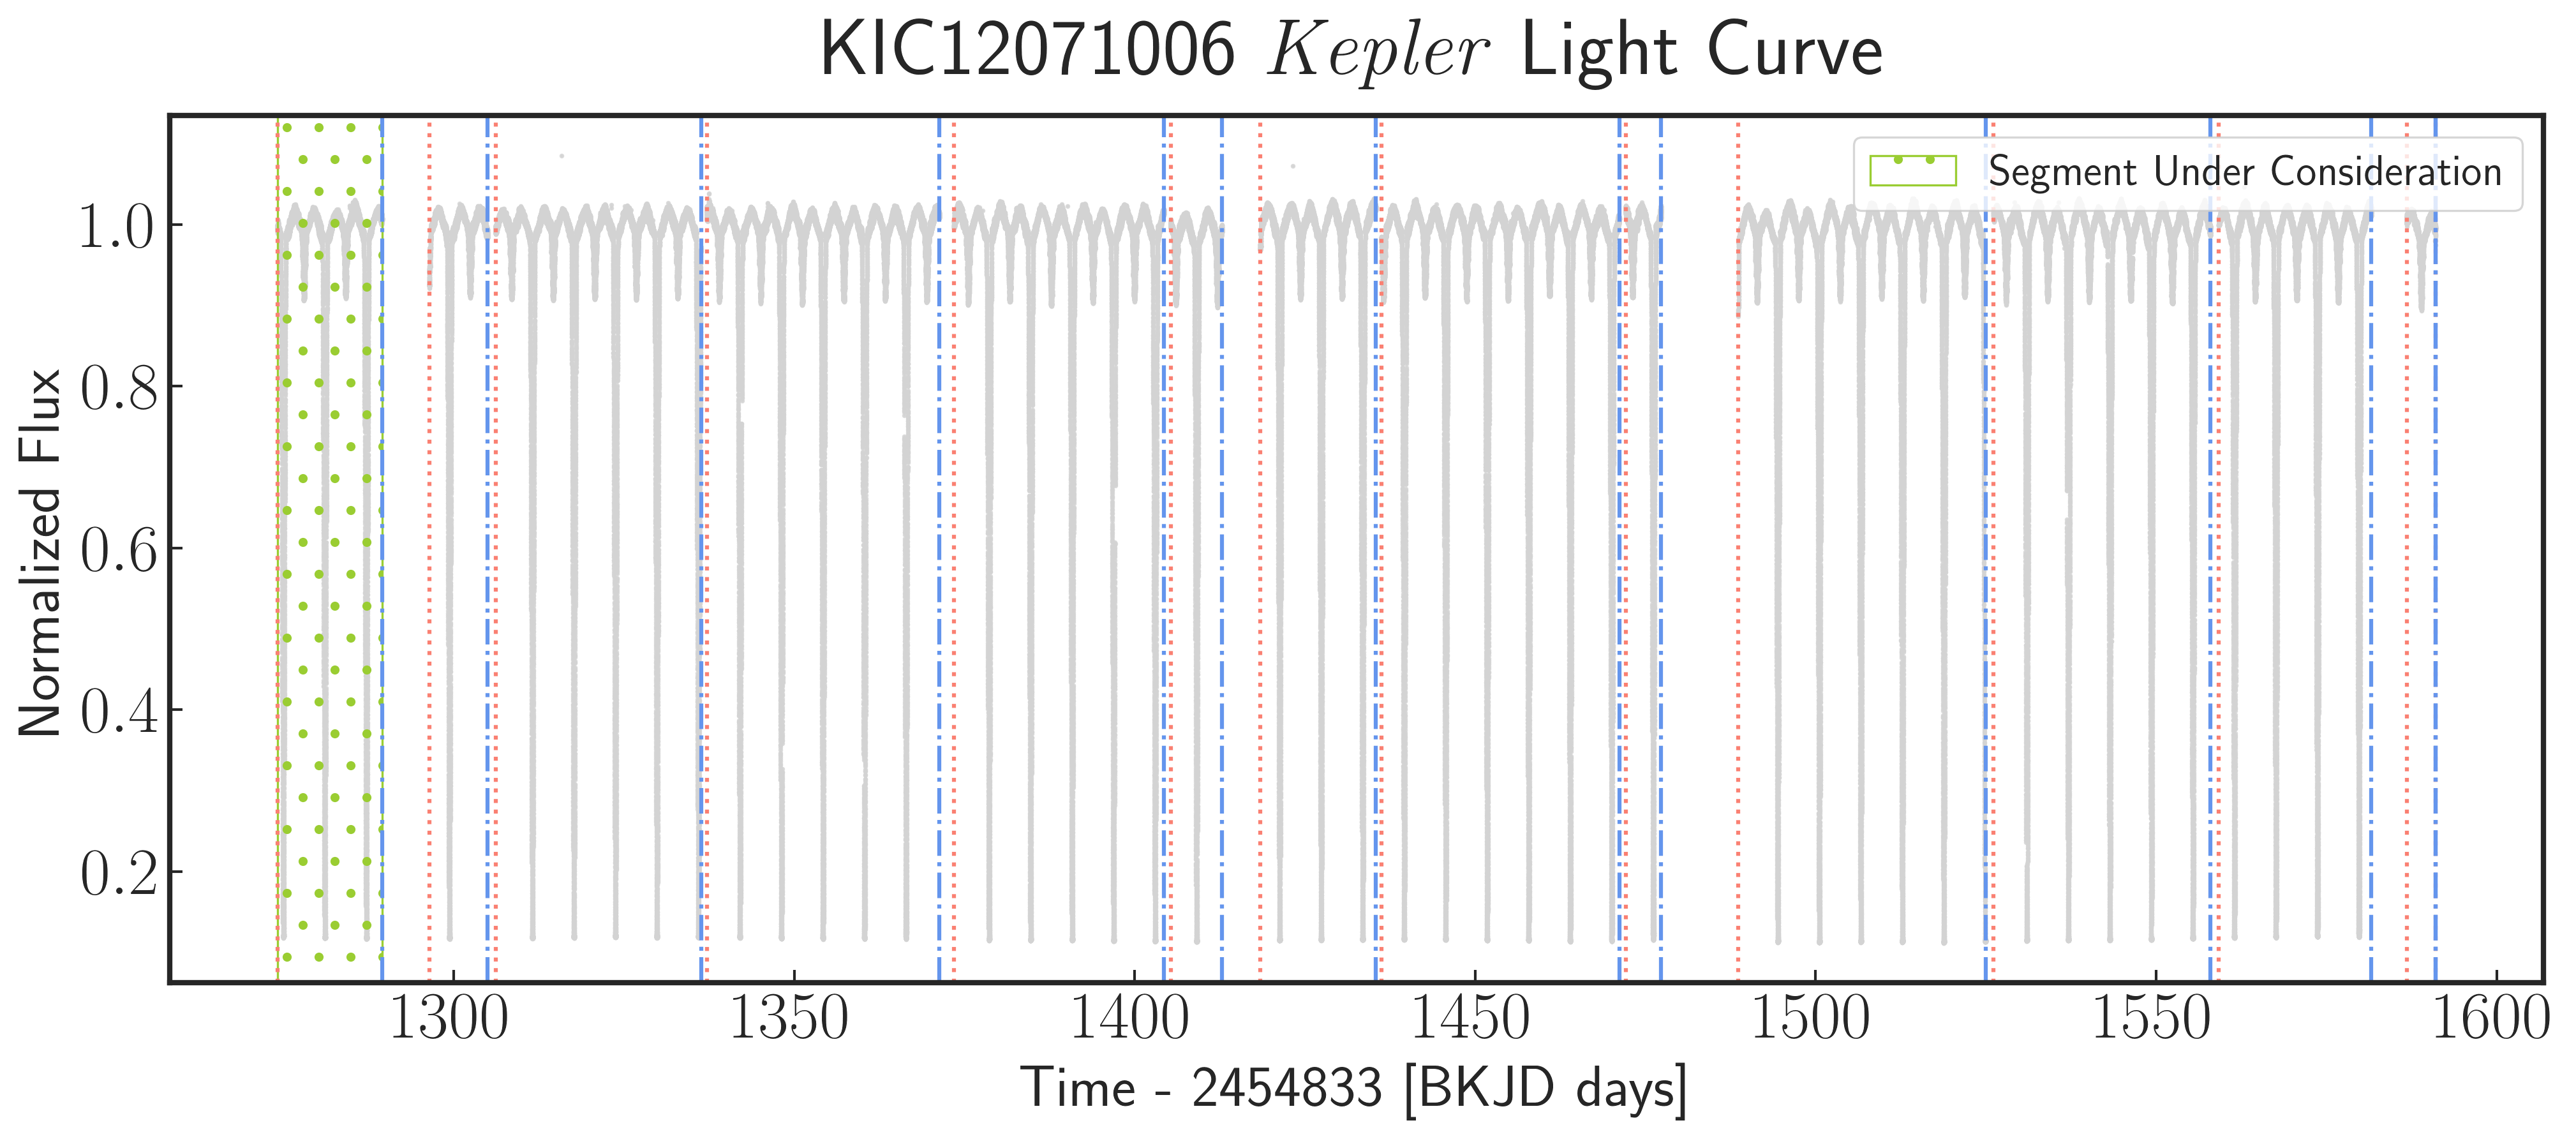

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
kepler_lc.scatter(c="lightgrey", s=1, alpha=0.8, ax=ax, label=None)

for i in init_gaps:
    ax.axvline(kepler_lc.time[i], color="salmon", lw=1.5, ls=":")
for e in end_gaps:
    ax.axvline(kepler_lc.time[e], color="cornflowerblue", lw=1.5, ls="-.")

ax.axvspan(min(kepler_lc[lc_mask].time), max(kepler_lc[lc_mask].time), color='yellowgreen', hatch='.', fill=False, label="Segment Under Consideration")
ax.set_xlabel(xlabel="Time - %i [BKJD days]" % kepler_tref, size=22)
ax.set_ylabel("Normalized Flux", size=22)
ax.set_title(r"KIC%s $\it{Kepler}$ Light Curve" % KIC, fontsize=30, y=1.03)
ax.legend(loc="upper right", fontsize=16)
fig.savefig(fpath_chunk + "data/lc_segment.png", dpi=300)

## Prepare the Data for `Exoplanet`

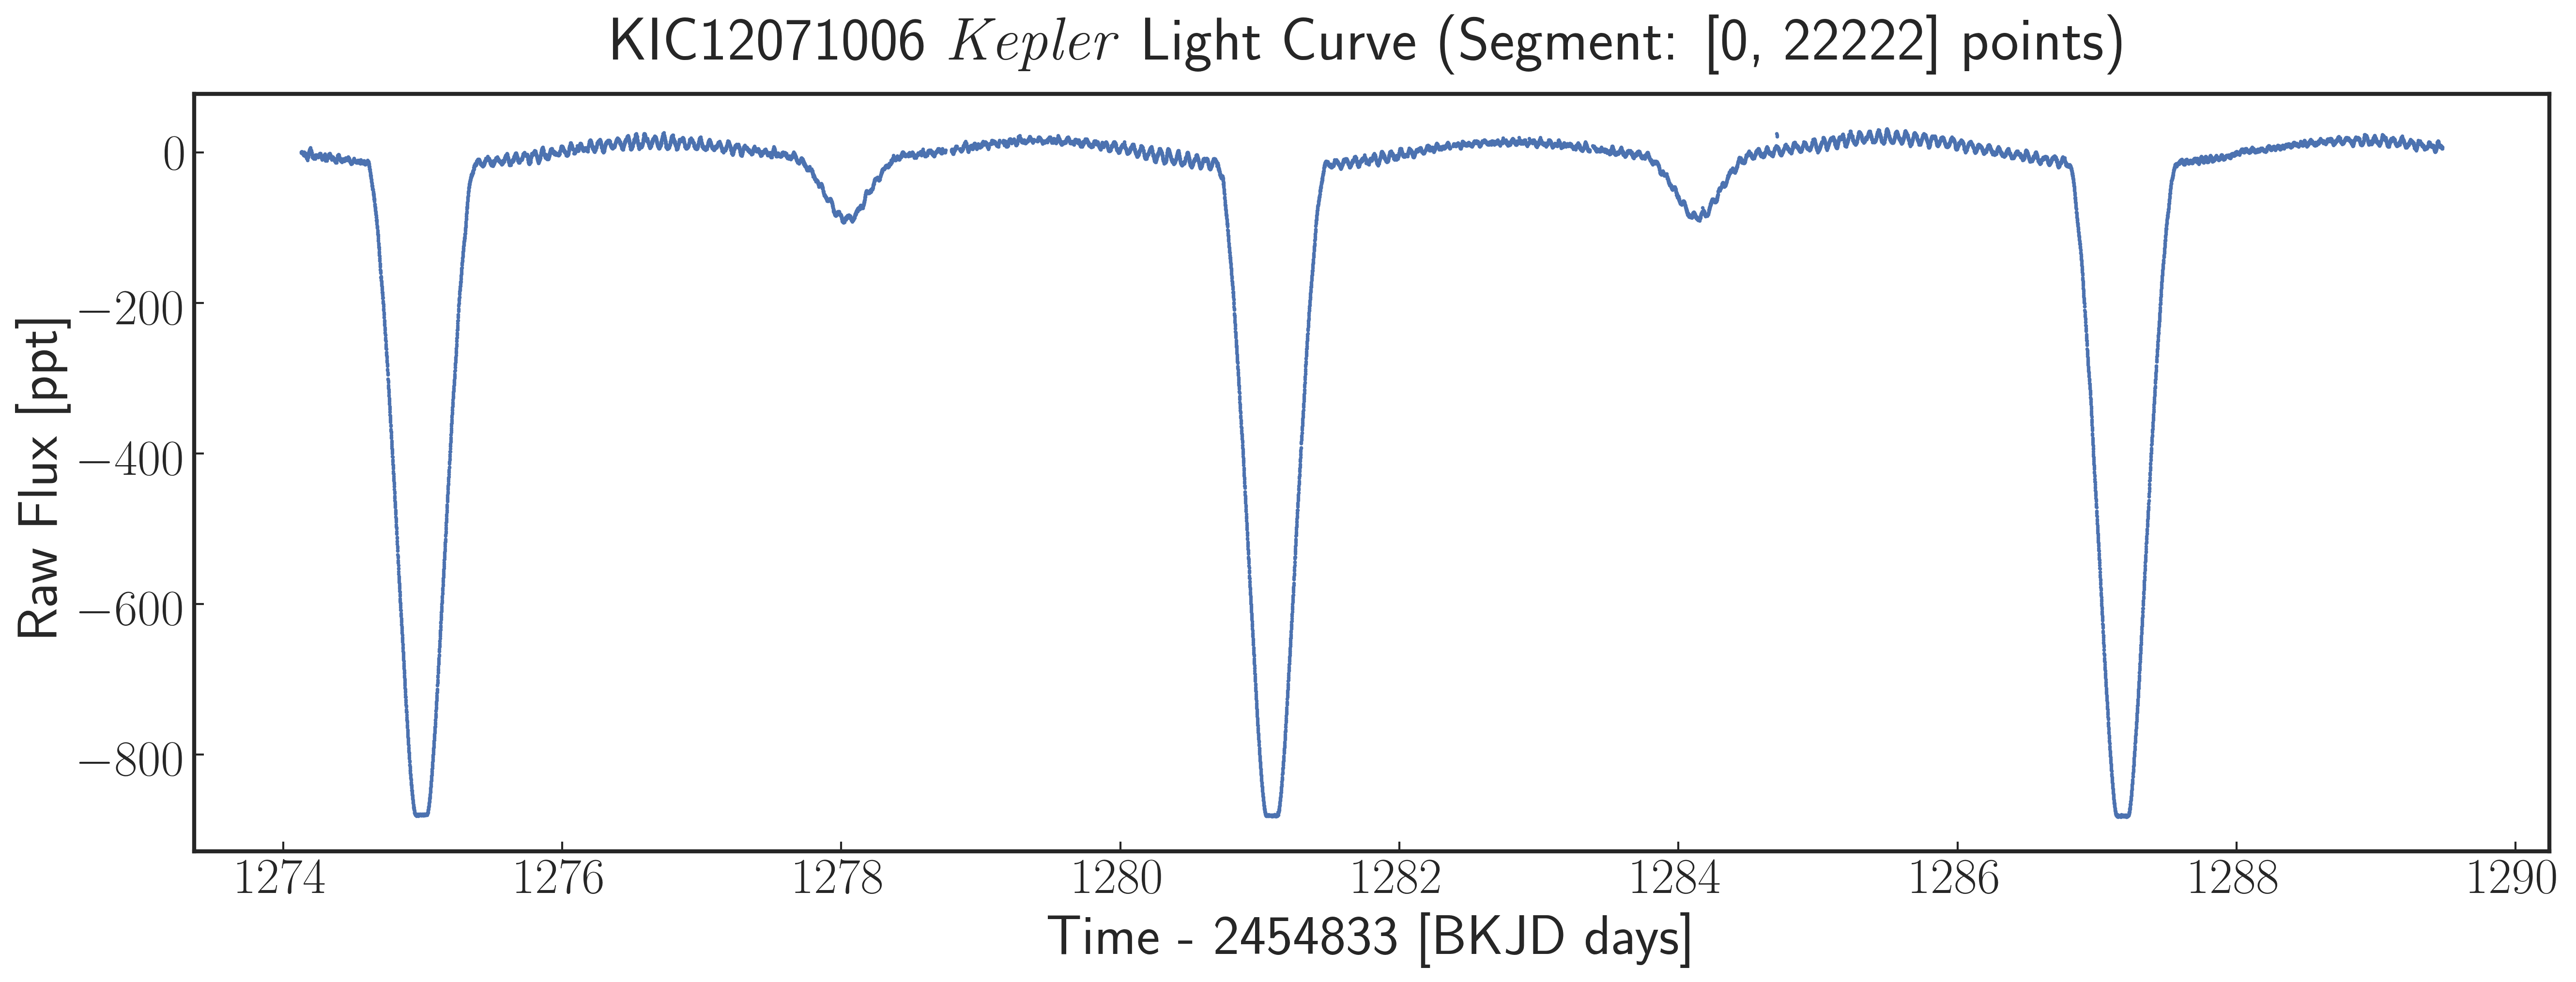

In [11]:
x = np.ascontiguousarray(kepler_lc.time[lc_mask], dtype=np.float64)
y = np.ascontiguousarray(kepler_lc.flux[lc_mask], dtype=np.float64)
yerr = np.ascontiguousarray(kepler_lc.flux_err[lc_mask], dtype=np.float64)
mu = np.median(y)

#preparing flux array for PHOEBE simulations
y_phoebe = y/mu        
lc_phoebe = np.column_stack((x, y_phoebe))
np.savetxt("lc_phoebe.txt", lc_phoebe, header="time [BKJD], raw flux [ppt]")

#preparing flux array for exoplanet package
y = (y / mu - 1) * 1e3 
lc_out = np.column_stack((x, y))
np.savetxt(fpath_chunk+"tfreq_analysis/lc_original.txt", lc_out, header="time [BKJD], raw flux [ppt]")

fig, ax = plt.subplots(1, 1, figsize=(18, 7))
ax.scatter(x, y, s=1)
ax.set_xlabel("Time - %i [BKJD days]" % kepler_tref, size=28)
ax.set_ylabel('Raw Flux [ppt]', size=28)
ax.set_title(r"KIC%s $\it{Kepler}$ Light Curve (Segment: [%i, %i] points)" %(KIC, init_chunk, end_chunk), fontsize=30, y=1.03)
fig.tight_layout()
fig.savefig(fpath_chunk + "data/lc.png", dpi=300)

## Extract Period and t0 of the Primary 

In [12]:
def bls_estimator(time, flux, flux_err, t_peclipse, minP, maxP, plot_bool):

    period_grid = np.exp(np.linspace(np.log(minP), np.log(maxP), 50000))
    bls = BoxLeastSquares(time, flux, flux_err)
    bls_power = bls.power(period_grid, 0.1, oversample=10)

    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    bls_period = bls_power.period[index]
    bls_t0 = bls_power.transit_time[index]
    bls_depth = bls_power.depth[index]

    transit_mask = bls.transit_mask(time, bls_period, t_peclipse, bls_t0)

    if plot_bool == True:
        fig, ax = plt.subplots(2, 1, figsize=(12, 10))
        fig.subplots_adjust(hspace=0.3)
        ax[0].axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
        ax[0].plot(np.log10(bls_power.period), bls_power.power, color="grey")
        ax[0].annotate("Period = {0:.4f} d".format(bls_period), (0, 1),
                       xycoords="axes fraction",
                       xytext=(5, -5),
                       textcoords="offset points",
                       va="top",
                       ha="left",
                       fontsize=12)
        ax[0].set_ylabel("BLS Power")
        ax[0].set_yticks([])
        ax[0].set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
        ax[0].set_xlabel(r"$\log_{10}$(Period)")

        # Plot the folded transit
        x_fold = (time - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
        m = np.abs(x_fold) < 0.4
        ax[1].scatter(x_fold[m], flux[m], color="grey")

        # Overplot the phase binned light curve
        bins = np.linspace(-0.5, 0.5, 200)
        denom, _ = np.histogram(x_fold, bins)
        num, _ = np.histogram(x_fold, bins, weights=flux)
        denom[num == 0] = 1.0
        ax[1].plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")
        ax[1].set_xlim(-0.3, 0.3)
        ax[1].set_ylabel("Detrended Flux")
        ax[1].set_xlabel("Time since Transit [d]")

    return bls_period, bls_t0, bls_depth

Compute the period of the signal. If the period is reported on the EB Villanoba catalog, cross-check it by running a BLS. If it's not reported, then use the period from the BLS. 

In [13]:
catalog = pd.read_csv('catalog_of_EBs_with_SC.csv', sep=",")  #Filtered EB Villanova Catalog

In [ ]:
min_bls_period = 1.
max_bls_period = 15.

if (KIC in catalog["#KIC"].to_list()):
    lit_period, lit_t0, pwidth, swidth = get_true_eb_values(KIC, catalog)
    
    print("--> Running BLS Estimators (from Exoplanet and Allesfitter Packages) with Pmin = %0.02f d, Pmax = %0.02f d.\n" %(min_bls_period, max_bls_period))

    bls_xo = xo.bls_estimator(x, y, yerr, 
                              duration   = pwidth, 
                              min_period = min_bls_period,
                              max_period = max_bls_period,
                              objective  = None,
                              method     = "fast",
                              oversample = 10)
    
    alles_period, _, _ = bls_estimator(x, y, yerr, pwidth, 1, 15, plot_bool=True)
    
    print("Period from Villanova EB Database = %0.06f [d]" % lit_period)
    print("Period from BLS (exoplanet) = %0.06f [d]" %bls_xo['peaks'][0]["period"])
    print("Period from BLS (allesfitter) = %0.06f [d]" %alles_period)

else:
    print("This target is not listed in the filtered Villanova EB Catalog.")
    user_input = input("Do you want to manually input P, T, pwidth, swidth? [y/n] ")

    if user_input == "n":
        print("\n--> Running a BLS periodogram to estimate P and T0 using the following BLS default parameters:\n")
        pwidth = 0.02  #estimate by eye
        swidth = pwidth/2.
        print("    *Min. period = %0.02fd\n    *Max. period = %0.02f d" %(min_bls_period, max_bls_period))
        print("    *pwidth = %0.02f d\n    *swidth = %0.02f d" %(pwidth, swidth))
        bls_xo = xo.bls_estimator(x, y, yerr, 
                              duration   = pwidth, 
                              min_period = 1,
                              max_period = 15,
                              objective  = None,
                              method     = "fast",
                              oversample = 10)
        
        lit_period, lit_t0, alles_depth = bls_estimator(x, y, yerr, pwidth, 1, 15, plot_bool=True)
        
        print("\nPeriod from BLS (exoplanet) = %0.06f [d]" %bls_xo['peaks'][0]["period"])
        print("Period from BLS (allesfitter) = %0.06f [d]" %lit_period)
        print("T0 of Primary eclipse (allesfitter) = %0.02f [d] " %lit_t0)

    else:
        lit_period = float(input("Expected Period [d] = "))
        lit_t0 = float(input("Expected T0 of Primary [d] = "))
        pwidth = float(input("Duration of Primary Eclipse [d] = "))
        swidth = float(input("Duration of Secondary Eclipse [d] = "))

print("--------------------------------\n\nOrbital Period = %0.08f d" % lit_period)
print("Time of Eclipse = %0.02f d" % lit_t0)
print("Duration of Primary Eclipse = %0.02f [d]" % pwidth)
print("Duration of Secondary Eclipse = %0.02f [d]" % swidth)

1.945
--> Running BLS Estimators (from Exoplanet and Allesfitter Packages) with Pmin = 1.00 d, Pmax = 15.00 d.



## Determine the T0 of the Secondary Star

In [ ]:
def get_tls_kwargs(name,
                   sigma=3.0,
                   progress_bool=True,
                   tls_kwargs=None,
                   quiet=False):
    
    params = tls.catalog_info(KIC_ID=name)  #mass comes first, radius comes second
    u, M_star, M_star_lerr, M_star_uerr, R_star, R_star_lerr, R_star_uerr = params

    if not quiet:
        print('TICv8 info:')
        print('Quadratic limb darkening u_0, u_1', u[0], u[1])
        print('Stellar radius', R_star, '+', R_star_lerr, '-', R_star_uerr)
        print('Stellar mass', M_star, '+', M_star_lerr, '-', M_star_uerr)
        print(" ")
        
    if tls_kwargs is None: tls_kwargs = {}

    #Stellar Radius
    tls_kwargs['R_star'] = float(R_star)
    tls_kwargs['R_star_min'] = R_star - sigma * R_star_lerr
    if tls_kwargs['R_star_min'] < 0: tls_kwargs['R_star_min'] = 0.08
    tls_kwargs['R_star_max'] = R_star + sigma * R_star_uerr

    #Stellar Mass
    tls_kwargs['M_star'] = float(M_star)
    tls_kwargs['M_star_min'] = M_star - sigma * M_star_lerr
    tls_kwargs['M_star_max'] = M_star + sigma * M_star_uerr
    if tls_kwargs['M_star_min'] < 0: tls_kwargs['M_star_min'] = 0.08

    #LD Coefficients
    tls_kwargs['u'] = u

    #Orbital Period
    if (lit_period-1.0) < 0: pmin = 0
    else: pmin = lit_period - 0.1

    tls_kwargs["P_min"] = pmin
    tls_kwargs["P_max"] = lit_period + 0.1

    return tls_kwargs


def get_t0_secondary(lc_masked, tls_kwargs):
    model = tls.transitleastsquares(lc_masked.time, lc_masked.flux,lc_masked.flux_err)
    results = model.power(M_star=tls_kwargs["M_star"],
                          M_star_min=tls_kwargs["M_star_min"],
                          M_star_max=tls_kwargs["M_star_max"],
                          R_star=tls_kwargs["R_star"],
                          R_star_min=tls_kwargs["R_star_min"],
                          R_star_max=tls_kwargs["R_star_max"],
                          u=tls_kwargs["u"],
                          period_min=tls_kwargs["P_min"],
                          period_max=tls_kwargs["P_max"])

    summarize_tls_results(results)
    return results.T0

def mask_transits(data, twindow, width, ref_t0):
    intransit = tls.transit_mask(data.time, lit_period, twindow * width * lit_period, ref_t0)  #multiply the duration pwdith by P to convert it from phase units to days
    eclipses = data[intransit]
    lc_masked = data[~intransit]
    return lc_masked, eclipses

def summarize_tls_results(results):
    print(f'Period = {results.period:.5f} +/- {results.period_uncertainty:.5f} d')
    print('Transit depth = ', format(results.depth, '.5f'))
    print("T0 = ", format(results.T0, '.5f'))
    print('Best duration (days) = ', format(results.duration, '.5f'))
    print('Signal detection efficiency (SDE) = ', results.SDE)
    print('Signal-to-noise ratio (SNR) = ', results.snr)

In [ ]:
transit_window = 1.2
tls_info = get_tls_kwargs(KIC)

#Mask primary eclipses
lc_primary_masked, primary_transits = mask_transits(kepler_lc[lc_mask], transit_window, pwidth, lit_t0) 

#Get T0 of the secondary from masked light curve
t0_secondary = get_t0_secondary(lc_primary_masked, tls_info)

#let's also get the light curve without any eclipses and the time of secondary eclipses
lc_wo_eclipses, secondary_transits = mask_transits(lc_primary_masked, transit_window, swidth, t0_secondary)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
fig.subplots_adjust(hspace=0.6)
lc_primary_masked.scatter(c='mediumslateblue', s=1, ax=ax[0],
                          xlabel="Time - %i [BKJD days]" % kepler_tref,
                          label=None)
lc_wo_eclipses.scatter(s=1,ax=ax[1], c="lightgray",
                        xlabel="Time - %i [BKJD days]" % kepler_tref,
                        label=None)
ax[0].set_title('No Primary Eclipses', fontsize=22)
ax[1].set_title('No Primary and No Secondary Eclipses', fontsize=22)
fig.savefig(fpath_chunk + "data/masked_transits.png")

print("\n * The reported period is P=%0.02f [d]. Note that P/2=%0.02f [d]." % (lit_period, lit_period / 2.))
print(" * The time of the secondary is %0.02f [d]." % t0_secondary)

#Save t0 of secondary 
t0s_out = np.savetxt(fpath_chunk + "data/t0_secondary.txt", [t0_secondary],  fmt='%0.10f',
                     header="The Time of the Secondary in BKJD is:")

## Other Calculations

In [ ]:
# Phase-fold the Light Curve
x_fold_in_phase = ((x - lit_t0 + 0.5 * lit_period) % lit_period) / lit_period - 0.5  #equivalent to cut_lc.fold(period=lit_period, t0 = lit_t0)
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.scatter(x_fold_in_phase, y, c="lightsteelblue", s=1)
ax.set_xlim([-0.5, 0.5])
ax.set_xlabel("Orbital Phase", size=30)
ax.set_ylabel('Raw Flux [ppt]', size=30)
ax.set_title(r"KIC%s $\it{Kepler}$ Phase-Folded Light Curve" % KIC,
             fontsize=25,
             y=1.02)
fig.savefig(fpath_chunk + "data/lc_folded.png", dpi=300)

# Calculate Time since Primary Eclipse
x_fold = (x - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.scatter(x_fold, y, c="lightsteelblue", s=1)
ax.set(xlim=(-0.5 * lit_period, 0.5 * lit_period))
ax.set_xlabel("Time since primary Eclipse [days]", size=30)
ax.set_ylabel("Relative flux [ppt]", size=30)
fig.tight_layout()

## Simplify the Light Curve

### Estimate the Phase Curve

In [ ]:
nbins = len(y) // 12  #1/10 is approx. 10 points per bin if uniformly distributed; this may not necessarily be the case, so we may have to divide by bigger number
print(len(x_fold), nbins)

In [ ]:
bin_edges = lit_period * np.linspace(-0.5, 0.5, nbins)
num, _ = np.histogram(x_fold, bin_edges, weights=y)
denom, _ = np.histogram(x_fold, bin_edges)
x_smooth = 0.5 * (bin_edges[1:] + bin_edges[:-1])
y_smooth = num / denom

In [ ]:
m_thresh = 0.5
m = np.abs(x_smooth) > m_thresh
fig, ax = plt.subplots(1,1)
ax.scatter(x_fold, y, c="lightsteelblue", label = "x$_{fold}$")
ax.scatter(x_smooth[m], y_smooth[m], c="salmon", label=r"x$_{smooth}$[m]")
ax.legend(fontsize=20)
ax.set(xlim=(-0.5 * lit_period, 0.5 * lit_period))
ax.set_xlabel("Time since primary Eclipse [days]", size=30);
ax.set_ylabel("Relative flux [ppt]", size=30);
ax.set_title(r"$m_{thresh}=%0.01f$" %m_thresh, size=35);

In [ ]:
second_phase = x_smooth[m][np.argmin(y_smooth[m])]
print("Second Phase:", second_phase)
x_smooth = np.concatenate(([2 * x_smooth[0] - x_smooth[1]], x_smooth,
                           [2 * x_smooth[-1] - x_smooth[-2]]))
y_smooth = np.concatenate(([y_smooth[-1]], y_smooth, [y_smooth[0]]))
mod = np.interp(x_fold, x_smooth, y_smooth)

In [ ]:
print(np.argwhere(np.isnan(y_smooth)))
print(np.argwhere(denom == 0))

Compute the out-of-eclipse residuals from this phase curve

In [ ]:
pc_thresh = 0.2
mask = (np.abs(x_fold - second_phase) > pc_thresh) & (np.abs(x_fold) > pc_thresh)
resid = y - mod
sigma = np.nanmedian(resid[mask]**2)  #compute median while ignorning nan
nan_residm = np.where(resid[mask] is np.nan)
print("Sigma of Out-of-Eclipse Residuals: %0.03f" % sigma)
mask[mask] &= np.abs(resid[mask]) < 20 * sigma

Plot smoothed phase curve

In [ ]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(16,10))
fig.subplots_adjust(hspace=0.0)
ax[0].scatter(x_fold, y, s=1, label = "Observed Flux")
ax[0].plot(x_smooth, y_smooth, lw = 2, c = 'salmon', label = 'Smoothed Flux');
ax[0].legend(fontsize=18, markerscale=5, loc = "lower right")
ax[0].set_ylabel("Raw Flux [ppt]", size=25);

ax[1].scatter(x_fold, y, s=1, alpha = 0.4, label = "Observed Flux")
ax[1].plot(x_smooth, y_smooth, lw = 2, c = 'salmon', alpha = 0.8,label = 'Smoothed Flux');
ax[1].set_xlabel("Orbital Phase", size=25)
ax[1].set_ylabel("Raw Flux [ppt]", size=25)
ax[1].set(ylim=(-y.max(),y.max()+5));
ax[1].legend(fontsize=20, markerscale=5, loc = "lower right");

fig.tight_layout()
fig.savefig(fpath_chunk+"data/lc_folded_fit.png", dpi=300)

Plot the Out-of-eclipse Residuals

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(14,10))
fig.subplots_adjust(hspace=0.3)
ax[0].scatter(x[mask], resid[mask], s=1)
ax[0].set_title("Out-of-Eclipses Residuals", fontsize=30,y=1.02)
ax[0].set_xlabel("Time - %i [BKJD days]" % kepler_tref, fontsize=25)
ax[0].set_ylabel("Raw Flux [ppt]", fontsize=25)
ax[1].scatter(x_fold[mask], resid[mask], s=1)
ax[1].set_xlabel("Phase [days]", fontsize=25)
ax[1].set_ylabel("Raw Flux [ppt]", fontsize=25)

fig.savefig(fpath_chunk + "data/ooe_residuals.png", dpi=300)

x_oot = x[mask]
y_oot = resid[mask]
yerr_oot = yerr[mask]

## Choose Frequency Grid for the Periodogram

In [ ]:
def ls_estimator(time, flux, frequencies, npeaks):
    #Function based on Dan's LS estimator code but adjusted for a variable frequency grid
    #(https://github.com/exoplanet-dev/exoplanet/blob/main/src/exoplanet/estimators.py)

    periods = 1. / frequencies
    model = LombScargle(time, flux)
    powers = model.power(frequencies, method="fast", normalization="psd")

    powers /= len(time)
    power_est = np.array(powers)

    # Identify Peaks
    peaks = xo.find_peaks(frequencies, powers, max_peaks=npeaks)

    return dict(periodogram=(frequencies, power_est), peaks=peaks, ls=model)


def detect_oscillations(time, flux, ls_model, optional_it):
    ls = ls_model["ls"]
    frequencies, powers = ls_model['periodogram']
    periods = 1.0 / frequencies
    best_frequency = frequencies[np.argmax(powers)]
    best_period = 1. / best_frequency
    print("Best Frequency = %0.04f d^-1" % best_frequency)

    #FAP Levels
    log_probs = np.array([-2, -4, -6])
    fals = ls.false_alarm_level(10.**log_probs)

    # Hack to remove nearby modes
    peak_freq = np.array([1.0 / ls_model["peaks"][0]["period"]])
    peak_log_power = [ls_model["peaks"][0]["log_power"]]

    for peak in ls_model["peaks"][1:]:
        freq = 1.0 / peak["period"]
        if np.any(np.abs(peak_freq - freq) < 0.2):
            continue
        peak_freq = np.append(peak_freq, freq)
        peak_log_power.append(peak["log_power"])
    print(
        f"--> I have found %s dominant frequencies (max. allowed nº of freqs: %s)"
        % (len(peak_freq), npeaks))

    # Only store peaks above FAP=10^-2
    peak_power = np.exp(peak_log_power)
    fap_mask = (peak_power > fals[0])
    peak_freq = peak_freq[fap_mask]
    peak_power = peak_power[fap_mask]
    print(f"--> I have found {len(peak_freq)} frequencies with FAP > 10^-2")

    #Plot periodogram
    fig = plt.figure(figsize=(20, 16))
    #fig.suptitle("Lomb Scargle Periodogram",y=1.02)
    fals_palette = sns.color_palette("coolwarm")
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(212)

    #Frequency domain
    ax1.plot(frequencies, powers, c='grey')
    for idx, (log_prob, fal) in enumerate(zip(log_probs, fals)):
        ax1.axhline(fal,
                    ls='--',
                    lw=2,
                    c=fals_palette[idx],
                    label=f'FAP = 10$^{{{log_prob}}}$')
    ax1.set_xlabel(r"Frequency $f$ [$d^{-1}$]", size=30)
    ax1.set_ylabel("Power", size=30)
    ax1.set_title("Frequency Domain", size=35, y=1.02)
    ax1.legend(fontsize=20)

    #Time domain
    ax2.plot(periods, powers, c='grey')
    ax2.axvline(best_period, alpha=0.2, lw=3, c='purple')
    for i, (log_prob, fal) in enumerate(zip(log_probs, fals)):
        ax2.axhline(fal,
                    ls='--',
                    lw=2,
                    color=fals_palette[i],
                    label=f'FAP = 10$^{{{log_prob}}}$')
    ax2.set_xlabel(r"Period [d]", size=30)
    ax2.set_ylabel("Power", size=30)
    ax2.set_title("Time Domain", size=35, y=1.02)
    ax2.legend(fontsize=20)

    #plot dots
    cdots = sns.color_palette("Paired", npeaks)

    for idx, (f, p) in enumerate(zip(peak_freq, peak_power)):
        ax1.plot(f, p, "o", c=cdots[idx])
        ax2.plot(1. / f, p, "o", c=cdots[idx])

    # Find harmonics within dist_to_integer
    dist_to_integer = 0.001  #1e-2
    orbital_frequency = 1.0 / lit_period

    freq_norm = frequencies / orbital_frequency
    peak_freq_norm = peak_freq / orbital_frequency
    resonant_peak_freq = freq_norm[
        np.abs(freq_norm - np.round(freq_norm)) <= dist_to_integer]

    ax3.plot(freq_norm, powers, color='grey')  #plot f/forb

    for r in resonant_peak_freq:
        ax3.axvline(r, ls=':', lw=1., c='navy')  # plot harmonics

    for (idx,peak) in enumerate(peak_freq_norm):  # plot peaks identified before
        ax3.plot(peak, peak_power[idx], "o", c=cdots[idx],label=r"$f/f_{orb}$=%0.03f" % peak)

    # Adjust x-lim of orbital harmonics plot for the ~~~aesthetics
    if len(peak_freq_norm) != 0:
        ax3.set_xlabel(r"f/f$_{orbit}$", size=30)
        ax3.set_ylabel("Power", size=30)
        ax3.set_title('Orbital Harmonics', size=35, y=1.02)
        ax3.set(xlim=(min(peak_freq_norm) - 1, 5 + max(peak_freq_norm)))
    ax3.legend(fontsize=18)

    # Save Plot
    if optional_it is not None:
        fig.tight_layout()
        fig.savefig(fpath_chunk + 'map/ls_periodogram_' + optional_it + '.png')
    else:
        fig.tight_layout()
        fig.savefig(fpath_chunk + 'map/ls_periodogram_0.png')

    print("--> I have found %s resonant frequencies in the periodogram!" %
          len(resonant_peak_freq))

    plt.pause(0.05)
    plt.close("all")

    return peak_freq, peak_power

### Apply Nyquist Theorem: 

Given the sampling frequency $f_s$ of a uniformly sampled real signal, the maximum frequency that can be detected without aliasing phenomena is (see VanderPlas 2018):
\begin{equation}
f_{max} = \frac{f_s}{2} \text{.}
\end{equation}

In [ ]:
orbital_frequency = 1/lit_period
minfr = 5*orbital_frequency #[d^-1] or 1/(total_duration) #5*orbital freq is about 10 hours
maxfr = 200 #float(input("Maximum Frequency [c/d]: "))  #[d^-1] #200 d^-1 is about 7 min
minfr, maxfr

In [ ]:
dt = np.median(np.diff(x)) # [d] # Sampling Rate --> Time span between consecutive samples
fs = 1.0/dt # Sampling frequency [1/d]
fmax = fs/2. #Nyquist frequency
total_duration = x.shape[0]/fs #total duration of data
dt, fs, total_duration  #Note that "dt" is approximately the same as the Kepler short-cadence of 58 seconds:

In [ ]:
N_samples_per_peak = 10 #shouldn't be less than 5. 10 often used as a conservative measure to have good spectral resol'n
df = 1/(total_duration*N_samples_per_peak)
grid_resolution = (maxfr-minfr)/df+1
freq_grid = np.linspace(minfr, maxfr, int(grid_resolution))

print("Nyquist Frequency for %s-cadence data = %0.03f [cycles·d^-1]  "% (cadence_type,fmax))
print("Min. Frequency = %0.02f d^-1\nMax. Frequency = %0.02f d^-1" %(min(freq_grid), max(freq_grid)))
print("Nº of samples per peak = %i" %N_samples_per_peak)
print("Grid Resolution = %i" %grid_resolution)
print("Delta(Frequency) btw Observations (using %i samples per peak) = %0.09f d^-1"%(N_samples_per_peak, df))
print("Delta(Frequency) btw Observations in our Frequency Grid = %0.09f d^-1"%(freq_grid[1]-freq_grid[0]))
print("Nº of Frequency Points (using a delta frequency of %0.08f d^-1) = %i" %(df, grid_resolution))
print("Length frequency grid: ", len(freq_grid))

### Compute LS Periodogram of the out-of-eclipse Residuals
<a class="anchor" id="section_1_5_2"></a>

In [ ]:
npeaks = 15 #maximum number of peaks
ls_res = ls_estimator(x_oot, y_oot, freq_grid, npeaks)

##Find the most dominant frequencies. We'll use them to initialize the model below. 
freq_osc_0, power_osc_0 = detect_oscillations(x_oot, y_oot, ls_res, None)

## Run `exoplanet` 

Some Useful Plotting Functions

In [ ]:
def add_sub_axes(axis, rect):
    fig = axis.figure
    left, bottom, width, height = rect
    trans = axis_to_fig(axis)
    figleft, figbottom = trans((left, bottom))
    figwidth, figheight = trans([width, height]) - trans([0, 0])

    return fig.add_axes([figleft, figbottom, figwidth, figheight])


def axis_to_fig(axis):
    fig = axis.figure
    def transform(coord):
        return fig.transFigure.inverted().transform(axis.transAxes.transform(coord))
    return transform

def pg_of_model(time, flux, osc, gp_pred, pc, lc, i=None):
    
    model_residuals_without_GP = flux - lc - pc - osc
    model_residuals_with_GP = flux - lc - pc - osc - gp_pred 
    
    pg_residuals_with_GP = ls_estimator(time, model_residuals_with_GP, freq_grid, npeaks)
    pg_residuals_no_GP = ls_estimator(time, model_residuals_without_GP, freq_grid, npeaks)
    pg_osc_model = ls_estimator(time, osc, freq_grid, npeaks)
    pg_gp_model = ls_estimator(time, gp_pred, freq_grid, npeaks)
    
    #For zoom-in plots
    xmin_sf, xmax_sf = min(freq_grid), 10
    xmin_hf, xmax_hf = 35, 55
    ymax1 = 1.2*max(pg_residuals_no_GP["periodogram"][1])
    ymax2 = 1.2*max(pg_osc_model["periodogram"][1])
    
    fig = plt.figure(figsize=(40,12))
    fig.subplots_adjust(wspace=0.2)
    ax1 = fig.add_subplot(121) #The first one being the number of rows in the grid, the second one being the number of columns in the grid and the third one being the position at which the new subplot must be placed.
    ax2 = fig.add_subplot(122)
    
    zoom1_sf = add_sub_axes(ax1, [0.5, 0.55, 0.45, 0.25])
    zoom1_hf = add_sub_axes(ax1, [0.5, 0.15, 0.45, 0.25])
    zoom2_sf = add_sub_axes(ax2, [0.5, 0.55, 0.45, 0.25])
    zoom2_hf = add_sub_axes(ax2, [0.5, 0.15, 0.45, 0.25])
    
    axes = [ax1, ax2]
    zoom1 = [ax1, zoom1_sf, zoom1_hf]
    zoom2 = [ax2, zoom2_sf, zoom2_hf]
    
    for idx,z in enumerate(zoom1):
        z.plot(pg_residuals_no_GP["periodogram"][0],pg_residuals_no_GP["periodogram"][1], c='grey', alpha=0.8, label = 'Residuals (GP not subtracted)')
        z.plot(pg_residuals_with_GP["periodogram"][0], pg_residuals_with_GP["periodogram"][1], c='orchid', lw = 1.5, label = 'Residuals (GP subtracted)') 
        
        if idx == 0:
            z.axvspan(xmin_sf, xmax_sf, color='yellowgreen', hatch='.', alpha = 0.8, fill=False)
            z.axvspan(xmin_hf, xmax_hf, color='cornflowerblue', hatch='/', alpha = 0.8, fill=False)
            z.legend(fontsize=20)
            z.set_xlabel(r"Frequency $f$ [$d^{-1}$]", size=30); 
            z.set_ylabel("Power", size=30)
            z.set_title("LS Periodogram of the Model Residuals", fontsize=36, y=1.03);
            
        elif idx == 1: 
            z.axvspan(xmin_sf, xmax_sf, color='yellowgreen', hatch='.', alpha = 0.3, fill=False)
            z.set(xlim=(xmin_sf, xmax_sf), ylim=(0,ymax1))
            z.set_xlabel(r"Frequency $f$ [$d^{-1}$]", size=15); 
            z.set_ylabel("Power", size=15)
            z.set_title(r"Zoomed-in ($x_{lim} = [%0.02f, %i]$, $y_{lim}=[%i,%0.4f]$)" %(xmin_sf, xmax_sf, 0, ymax1), fontsize=20, y=1.02)
        else:
            z.axvspan(xmin_hf, xmax_hf, color='cornflowerblue', hatch='/', alpha = 0.3, fill=False)
            z.set(xlim=(xmin_hf, xmax_hf), ylim=(0, ymax1)) 
            z.set_xlabel(r"Frequency $f$ [$d^{-1}$]", size=15); 
            z.set_ylabel("Power", size=15)
            z.set_title(r"Zoomed-in ($x_{lim} = [%i, %i]$, $y_{lim}=[%i,%0.4f]$)" %(xmin_hf, xmax_hf, 0, ymax1), fontsize=20, y=1.02) 
        
    
    for idx,z in enumerate(zoom2):
        z.plot(pg_osc_model["periodogram"][0], pg_osc_model["periodogram"][1], c=cdict["osc"], label = "Osc. Model")
        z.plot(pg_gp_model["periodogram"][0], pg_gp_model["periodogram"][1], c=cdict["gp_pred"], label = "GP. Model")
        
        if idx == 0:
            z.axvspan(xmin_sf, xmax_sf, color='yellowgreen', hatch='.', alpha = 0.8, fill=False)
            z.axvspan(xmin_hf, xmax_hf, color='cornflowerblue', hatch='/', alpha = 0.8,  fill=False)
            z.set_title("LS Periodogram of the Oscillation and GP Models", fontsize=36, y=1.03);
            z.set_xlabel(r"Frequency $f$ [$d^{-1}$]", size=30); 
            z.set_ylabel("Power", size=30)
            z.legend(fontsize=20)
        elif idx == 1: 
            z.axvspan(xmin_sf, xmax_sf, color='yellowgreen', hatch='.', alpha = 0.3, fill=False)
            z.set(xlim=(xmin_sf, xmax_sf), ylim=(0, ymax2))
            z.set_xlabel(r"Frequency $f$ [$d^{-1}$]", size=15); 
            z.set_ylabel("Power", size=20)
            z.set_title(r"Zoomed-in ($x_{lim} = [%0.02f, %i]$, $y_{lim}=[%i,%0.4f]$)" %(xmin_sf, xmax_sf, 0, ymax2), fontsize=20, y=1.02)
        else:
            z.axvspan(xmin_hf, xmax_hf, color='cornflowerblue', hatch='/', alpha = 0.3, fill=False)
            z.set(xlim=(xmin_hf, xmax_hf), ylim=(0, ymax2))
            z.set_xlabel(r"Frequency $f$ [$d^{-1}$]", size=15); 
            z.set_ylabel("Power", size=20)
            z.set_title(r"Zoomed-in ($x_{lim} = [%i, %i]$, $y_{lim}=[%i,%0.4f]$)" %(xmin_hf, xmax_hf, 0, ymax2), fontsize=20,y=1.02) 
        
    if i is not None: 
        fig.tight_layout()
        fig.savefig(fpath_chunk+"map/pg_models_"+i+".png", dpi=300)
        
    plt.pause(0.01); plt.close("all")
    
    return pg_osc_model, pg_gp_model

In [ ]:
cdict = {
    "lc": "cornflowerblue", 
    "gp_pred": "orange", 
    "pc": "green", 
    "osc": "crimson", 
    "zoom_models": "lavender", 
    "zoom_osc": "wheat"}

legend_fsize = 22
label_size = 35
title_size = 40

def evaluate_model(flux, best_model, map_solution, i):
    print("\n-----> Obtaining Maximum a Posteriori Parameters ")
    
    with best_model:
        gp_pred = xo.eval_in_model(best_model.gp_lc_pred, map_solution) + map_solution["mean_lc"]
        lc = xo.eval_in_model(best_model.model_lc, map_solution)
        osc, pc = xo.eval_in_model([best_model.osc, best_model.phase_curve], map_solution)
        w = xo.eval_in_model(best_model.w, map_solution)
        
    model_residuals = best_model.y - lc - pc - osc #- gp_pred 
    model_residuals_noGP = best_model.y - lc - pc - osc - gp_pred
    
    x_fold = (best_model.x - map_solution["t0"]) % map_solution["period"] / map_solution["period"]
    inds = np.argsort(x_fold)    
    
    fig = plt.figure(figsize=(32,28.5))
    fig.subplots_adjust(hspace=1.2)
    ax00 = fig.add_subplot(421)
    ax01 = fig.add_subplot(422)
    ax10 = fig.add_subplot(423)
    ax11 = fig.add_subplot(424)
    ax20 = fig.add_subplot(425)
    ax21 = fig.add_subplot(426)
    ax30 = fig.add_subplot(414)
        
    ax00.plot(best_model.x, best_model.y, "k.", alpha=0.5, label = 'Observed LC')
    ax00.plot(best_model.x, lc, c=cdict["lc"], label = 'Eclipse Model')
    ax00.plot(best_model.x, gp_pred, c=cdict["gp_pred"], lw=2, label = 'GP Model')
    ax00.plot(best_model.x, pc, c=cdict["pc"], label = 'Phase Curve Model')
    ax00.plot(best_model.x, osc, c=cdict["osc"], label = 'Oscillation Model')
    ax00.legend(fontsize=legend_fsize, loc='lower left')
    ax00.set_title("MAP Model LC",fontsize=title_size)
    ax00.set_xlabel("Time - %i [BKJD days]"%kepler_tref, size=label_size)
    ax00.set_ylabel("Raw flux [ppt]", size=label_size)
        
    ax01.plot(best_model.x, osc, c=cdict["osc"], alpha=0.8,label = "Oscillation Model")
    ax01.plot(best_model.x, model_residuals, c='lightsteelblue', alpha=0.8, label = 'Residuals = Observed LC - (Eclipse Model + PC Model + Osc. Model)')
    ax01.plot(best_model.x, gp_pred, marker='.', c=cdict["gp_pred"], alpha=0.6, label = "GP Model")
    ax01.legend(fontsize=legend_fsize, loc="upper right")
    ax01.set_xlabel("Time - %i [BKJD days]"%kepler_tref, size=label_size)
    ax01.set_ylabel("Raw Flux [ppt]", size=label_size)
    ax01.set_title("Light Curve Residuals",fontsize=title_size)
        
    ax10.plot(best_model.x, best_model.y, "k.", alpha=0.5, label = 'Observed LC')
    ax10.plot(best_model.x, osc, c=cdict["osc"], label = 'Oscillations Model')
    ax10.plot(best_model.x, pc, c=cdict["pc"], lw=2, label = 'Phase Curve Model')
    ax10.plot(best_model.x, gp_pred, c=cdict["gp_pred"], label = 'GP Model')
    ax10.axvspan(min(best_model.x), min(best_model.x)+2, facecolor=cdict["zoom_models"], alpha=0.7, label='Zoomed Region')
    ax10.legend(fontsize=legend_fsize)
    ax10.set_title("MAP Model LC",fontsize=title_size)
    ax10.set(
        xlim = (best_model.x.min(), best_model.x.max()), 
        ylim = (-(best_model.y.max()+5), best_model.y.max()+5) #-20,20
    )
    ax10.set_xlabel("Time - %i [BKJD days]"%kepler_tref, size=label_size)
    ax10.set_ylabel("Raw flux [ppt]", size=label_size)

    ax11.plot(best_model.x, best_model.y, "k.", alpha=0.2, label = 'Observed LC')
    ax11.plot(best_model.x, osc, c=cdict["osc"], lw=2, label = 'Oscillations Model')
    ax11.plot(best_model.x, pc, c=cdict["pc"], lw=2, label = 'Phase Curve Model')
    ax11.plot(best_model.x, gp_pred, c=cdict["gp_pred"], lw=2, label = 'GP Model')
    ax11.axvspan(min(best_model.x), min(best_model.x)+2, facecolor=cdict["zoom_models"], alpha=0.5, label='Zoomed Region')
    ax11.legend(fontsize=legend_fsize,loc="upper left")
    ax11.set_title("MAP Model LC (Zoomed-in)",fontsize=title_size)
    ax11.set(
        xlim = (best_model.x.min(),best_model.x.min()+2),
        ylim = (-(best_model.y.max()+5), best_model.y.max()+5)
    )
    
    ax11.set_xlabel("Time - %i [BKJD days]"%kepler_tref, size=label_size)
    ax11.set_ylabel("Raw flux [ppt]", size=label_size)
        
    ax20.plot(best_model.x, best_model.y - lc - pc - gp_pred, "k.", alpha=0.2, label = 'Observed LC - (Eclipse Model + PC Model + GP. Model)') #
    ax20.plot(best_model.x, osc, c=cdict["osc"], label = "Oscillations Model")
    ax20.axvspan(min(best_model.x), min(best_model.x)+2, facecolor=cdict["zoom_osc"], alpha=0.3,label='Zoomed Region')
    ax20.legend(fontsize=legend_fsize, loc="upper right")
    ax20.set_title("Oscillation Model", fontsize=title_size)
    ax20.set_xlabel("Time - %i [BKJD days]"%kepler_tref, size=label_size)
    ax20.set_ylabel("Raw Flux [ppt]", size=label_size)
    ax20.set_xlim(best_model.x.min(), best_model.x.max())
        
    ax21.plot(best_model.x, best_model.y - lc - pc - gp_pred, "k.", alpha=0.2, label = 'Observed LC - (Eclipse Model + PC Model + GP Model)') #
    ax21.plot(best_model.x, osc, c=cdict["osc"], label = "Oscillations Model")
    ax21.axvspan(best_model.x.min(),best_model.x.min()+2, facecolor=cdict["zoom_osc"], alpha=0.1, label='Zoomed Region')
    ax21.legend(fontsize=legend_fsize,loc="upper right")
    ax21.set_title("Oscillation Model (Zoomed-in)", fontsize=title_size)
    ax21.set_xlim(best_model.x.min(),best_model.x.min()+2)
    ax21.set_xlabel("Time - %i [BKJD days]"%kepler_tref, size=label_size)
    ax21.set_ylabel("Raw Flux [ppt]", size=label_size)
            
    ax30.plot(x_fold[inds], best_model.y[inds] - gp_pred[inds] - osc[inds], "k.", alpha=0.2, label = 'Observed LC - (GP Model + Oscillation Model)')
    ax30.plot(x_fold[inds] - 1, best_model.y[inds] - gp_pred[inds] - osc[inds], "k.", alpha=0.2)
    ax30.plot(x_fold[inds], lc[inds], c = cdict["lc"], lw=2, label = "Eclipse Model")
    ax30.plot(x_fold[inds] - 1, lc[inds], c = cdict["lc"], lw=2)
    ax30.plot(x_fold[inds], pc[inds], c = cdict["pc"], lw=2)
    ax30.plot(x_fold[inds] - 1, pc[inds], c = cdict["pc"], lw=2, label = "Phase Curve Model")
    ax30.legend(fontsize=legend_fsize, loc="lower right")
    ax30.set_title("Detrended Light Curve", fontsize=title_size)
    ax30.set_xlim(-1, 1)
    ax30.set_xlabel("Orbital Phase",  size=label_size)
    ax30.set_ylabel("De-trended flux [ppt]", size=label_size)
        
    fig.tight_layout()
    fig.savefig(fpath_chunk+"map/map_model_"+i+".png")
    plt.pause(0.05); 
    plt.close("all")
    
    
    fig, ax = plt.subplots(1,1, figsize=(16,8))
    ax.scatter(best_model.x, best_model.y, s=1, c="lightgrey")
    ax.scatter(best_model.x, model_residuals_noGP, s=5, c="salmon", label = "Model Residuals (Observed LC - Eclipse Model - PC Model - Osc Model - GP Model)")
    ax.set_ylim(min(model_residuals_noGP), max(model_residuals_noGP))
    ax.set_title("Residuals", fontsize=title_size)
    ax.set_xlabel("Time - %i [BKJD days]"%kepler_tref, size=label_size)
    ax.set_ylabel("Raw Flux [ppt]", size=label_size)
    fig.tight_layout()
    fig.savefig(fpath_chunk+"map/residuals_"+i+".png")
    
    plt.pause(0.05); 
    plt.close("all")
    
    return model_residuals, osc, gp_pred, pc, lc, w

### Define `exoplanet` Model
<a class="anchor" id="section_1_5_3"></a>

In [ ]:
def build_model(time, flux, flux_err, map_pr, osc_freqs, mask=None):

    print("\n----->  Printing Best Initial Guesses\n")
    print("Nº of Oscillation Frequencies Used: %s" % (len(osc_freqs)))
    print("P = %0.04f d" % map_pr['period'])
    print("t0 = %0.04f d" % map_pr['t0'])
    print("b = %0.04f" % map_pr['b'])
    
    if mask is None:
        mask = np.ones_like(time, dtype=bool)

    with pm.Model() as model:
        print("\n----->  Initializing the Model\n")
        
        # Systemic parameters
        u1 = xo.QuadLimbDark("u1")  #vector of LD coefficients for primary body
        u2 = xo.QuadLimbDark("u2")  #vector of LD coefficients for secondary body

        # Parameters describing the primary: could include priors based on isochrones or similar
        M1 = pm.Lognormal("M1", mu=0.0, sigma=10.0)
        R1 = pm.Lognormal("R1", mu=0.0, sigma=10.0)

        # Secondary ratios
        k = pm.Lognormal("k", mu=0.0, sigma=10.0)  # radius ratio
        q = pm.Lognormal("q", mu=0.810, sigma=0.01)  # mass ratio
        s = pm.Lognormal("s", mu=np.log(0.5), sigma=10.0)  # surface brightness ratio
        
        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=k, testval=map_pr['b'])
        period = pm.Lognormal("period", mu=np.log(map_pr['period']), sigma=1.0) 
        t0 = pm.Normal("t0", mu=map_pr['t0'], sigma=1.0)  #lit_t0

        ecosw = 0.25 * np.pi * (2 * (second_phase + lit_period) / lit_period - 1)
        ecs = xo.UnitDisk("ecs", testval=np.array([ecosw, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sqrt(tt.sum(ecs**2)))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", k * R1)
        M2 = pm.Deterministic("M2", q * M1)
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        #Track parameters of interest
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)
        pm.Deterministic("rho_circ", orbit.rho_star)  #implied density

        # Set up the LC model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, s)
        model_lc = 1e3 * lc.get_light_curve(orbit=orbit, r=R2, t=time[mask])[:,0]

        # Oscillation model using frequencies from periodogram
        arg = osc_freqs[None, :] * time[mask, None]
        X = np.concatenate([np.cos(2 * np.pi * arg), np.sin(2 * np.pi * arg)], axis=1)
        
        # Phase curve: mixture of harmonics of the period. 6th order seems to work well based on trial and error
        phi = ((time[mask] - t0) / period) % 1.0
        n_expand = 6
        comps = tt.stack(
            [tt.sin(2 * (n + 1) * np.pi * phi) for n in range(n_expand)] +
            [tt.cos(2 * (n + 1) * np.pi * phi) for n in range(n_expand)],
            axis=1)

        #Noise model for the light curve | Transit jitter & GP parameters
        # Transit jitter & GP parameters
        med_yerr = np.median(flux_err[mask])
        std = np.std(flux[mask])
        sigma_lc = pm.InverseGamma("sigma_lc",testval=1.0, **xo.estimate_inverse_gamma_parameters(0.1, 2.0))
        sigma_gp = pm.InverseGamma("sigma_gp", testval=2.0,**xo.estimate_inverse_gamma_parameters(1.0, 5.0))
        rho_gp = pm.InverseGamma("rho_gp", testval=2.0,**xo.estimate_inverse_gamma_parameters(1.0, 5.0))
        kernel_lc = terms.SHOTerm(sigma=sigma_gp, w0=2*np.pi/rho_gp, Q=1.0 / np.sqrt(2))  #amplitude, frequency, damping (https://celerite2.readthedocs.io/en/latest/api/python/#celerite2.terms.SHOTerm)
        
        #Condition the light curve model on the data
        gp_lc = GaussianProcess(kernel_lc, t=time[mask], yerr=tt.zeros(mask.sum())**2 + sigma_lc**2)  #3rd argument: should be the variance to add along the diagonal, not the std

        #note: never invert a matrix directly (https://github.com/dfm/gp/blob/main/solutions.ipynb).
        D = tt.concatenate((X, comps, tt.ones((mask.sum(), 1))), axis=1)
        DT = D.T
        DTD = tt.dot(DT, gp_lc.apply_inverse(DT.T)) + 0.01**2 * tt.eye(2 * (len(osc_freqs) + n_expand) + 1)
        DTy = tt.dot(DT, gp_lc.apply_inverse((flux[mask] - model_lc)[:, None]))
        factor = tt.slinalg.cholesky(DTD)
        weights = tt.slinalg.solve_upper_triangular(factor.T, tt.slinalg.solve_lower_triangular(factor, DTy))[:, 0]
        w = pm.Deterministic("w", weights[:2 * len(osc_freqs)])
        
        osc = tt.dot(X, w)
        amps = pm.Deterministic("amps", weights[2 * len(osc_freqs):2 * n_expand + 2 * len(osc_freqs)])
        phase_curve = tt.dot(comps, amps)

        mean_lc = pm.Deterministic("mean_lc", weights[-1])
        gp_lc.marginal("obs_lc", observed=flux[mask] - tt.dot(D, weights) - model_lc)  #likelihoood for the observations
        
        # Optimize logp to obtain the Maximum a Posteriori params given simuated dataset
        map_soln = model.test_point
        map_soln = pmx.optimize(map_soln, vars=[R1, k, s, b, u1, u2])
        map_soln = pmx.optimize(map_soln, vars=[sigma_gp, rho_gp, sigma_lc])
        map_soln = pmx.optimize(map_soln)

        model.X = X
        model.osc = osc
        model.phase_curve = phase_curve
        model.gp_lc = gp_lc
        model.w = w
        model.model_lc = model_lc
        model.gp_residuals = flux[mask] - tt.dot(D, weights) - model_lc
        model.gp_lc_pred = gp_lc.predict(model.gp_residuals, include_mean=False)

        model.x = time[mask]
        model.y = flux[mask]
        
    return model, map_soln


def sigma_clip(time, flux, flux_err, map_pr, osc_freqs):
    mask = np.ones(len(time), dtype=bool)
    num = len(mask)

    for i in range(10):
        model, map_soln = build_model(time, flux, flux_err, map_pr, osc_freqs, mask)

        with model:
            mdl = xo.eval_in_model(
                model.model_lc + model.gp_lc_pred + model.osc, map_soln)

        resid = flux[mask] - mdl
        sigma = np.sqrt(np.median((resid - np.median(resid))**2))
        mask[mask] = np.abs(resid - np.median(resid)) < 5.0 * sigma

        print("Sigma clipped {0} light curve points".format(num - mask.sum()))

        if num == mask.sum():
            break
        num = mask.sum()

    return model, map_soln, mask

Loop will stop when there are no more frequencies with FAP $<10^{-2}$

In [ ]:
plot_bool = True  # False if you don't want to see MAP model plots.
model_results = {}
ls_results = {}

#Store MAP for model components
osc_models = {}
w_models, X_models = {}, {}
gp_models = {}
pc_models = {}
lc_models = {}
map_results = {}
residuals_list = {}

xl = {}
yl = {}
yl_err = {}

for i in range(1, 20): #redo with a while?
    print("\n               ITERATION %s\n*******************************************"% i)
    if i == 1:
        ls_results[i] = [freq_osc_0, power_osc_0]  #initial freqs
        map_init = {
            'period': lit_period,
            't0': lit_t0,
            'b': 1.0,
            'sigma_lc': 1.0,
            'sigma_gp': 1.0,
            'rho_gp': 1.0
        }

        #Initialize the Model
        mod_i, map_i, mask_i = sigma_clip(x, y, yerr, map_init, freq_osc_0)

        #Calculate model residuals & plot MAP
        residuals, best_osc, best_gp, best_pc, best_lc, best_w = evaluate_model(y[mask_i], mod_i, map_i, str(i))

        #Plot periodogram of (1) residuals with/without GPs, and of (2) osc. and GP models
        pg_of_model(x[mask_i], y[mask_i], best_osc, best_gp, best_pc, best_lc,str(i))

        #Run periodogram of the residuals
        print("\n----->  Generating Periodogram of the Residuals")
        ls_res_i = ls_estimator(x[mask_i], residuals, freq_grid, npeaks)
        freq_osc_i, power_osc_i = detect_oscillations(x[mask_i], residuals, ls_res_i, str(i))

        #Update LC
        xl[i] = x[mask_i]
        yl[i] = y[mask_i]
        yl_err[i] = yerr[mask_i]
     
    elif (i > 1) and (len(freq_osc_i) != 0):

        ls_results[i] = [freq_osc_i, power_osc_i]
        freq_osc_cumulative, power_osc_cumulative = np.hstack([(freqs, powers) for (freqs, powers) in ls_results.values()])
        print("Accumulated frequencies:", len(freq_osc_cumulative))

        #Initialize the Model
        mod_i, map_i, mask_i = sigma_clip(xl[i - 1], yl[i - 1], yl_err[i - 1], map_init, freq_osc_cumulative)

        #Calculate model residuals & plot MAP 
        residuals, best_osc, best_gp, best_pc, best_lc, best_w = evaluate_model(yl[i - 1][mask_i], mod_i, map_i, str(i))

        #Plot periodogram of (1) residuals with/without GPs, and of (2) osc. and GP models
        pg_of_model(xl[i - 1][mask_i], yl[i - 1][mask_i], best_osc, best_gp, best_pc, best_lc, str(i))

        #Run periodogram of the residuals
        print("\n----->  Generating Periodogram of the Residuals")
        ls_res_i = ls_estimator(xl[i - 1][mask_i], residuals, freq_grid,npeaks)
        freq_osc_i, power_osc_i = detect_oscillations(xl[i - 1][mask_i], residuals, ls_res_i,str(i))

        #Update LC
        xl[i] = xl[i - 1][mask_i]
        yl[i] = yl[i - 1][mask_i]
        yl_err[i] = yl_err[i - 1][mask_i]

    else:
        print("The last periodogram does not show more significant frequencies.")
        
        break
    
    #Store the results
    model_results[i] = mod_i
    map_results[i] = map_i
    
    #store models
    X_models[i] = mod_i.X
    w_models[i] = best_w
    osc_models[i] = best_osc
    gp_models[i] = best_gp
    pc_models[i] = best_pc
    lc_models[i] = best_lc
    residuals_list[i] = residuals

In [ ]:
niterations = i-1
print("We have needed %i iterations to detect pulsation frequencies!" %(niterations))

## Evaluate Results

### Estimate Time of Periastron Passage 

We'll first retrieve MAP eccentricity $\varepsilon$ and argument of periastron $\omega$. Recall that the argument (or longitude) of periastron $\omega$ is the angle from the ascending node to the periastron. It ranges from 0 <= $\omega$ <= 360º and it is undefined when i = 0 or 180° (equatorial orbit) or e = 0 (circular orbit). Note: The argument of the periastron of the secondary component differs by $\pi$ from the argument of the periastron of the primary

In [ ]:
ecc_map = []
omega_map = []
period_map = []
t0_map = []
for i in range(1,niterations+1):
    ecc_map.append(map_results[i]["ecc"])
    omega_map.append(map_results[i]["omega"])
    period_map.append(map_results[i]["period"])
    t0_map.append(map_results[i]["t0"])
    
ecc_mean = np.mean(ecc_map)
omega_mean = np.mean(omega_map) #in radians

print("Our Model suggests that the eccentricity of this system is about %0.05f." %ecc_mean)
print("Its argument of periastron is about %0.02f radians (or %0.02f degrees)." %(omega_mean, 360+omega_mean*180./np.pi))

#reported values in https://arxiv.org/pdf/1306.1819.pdf: 
#   *eccentricity = 0.288 (see https://arxiv.org/pdf/1306.1819.pdf)
#   *argument of periastron = 328.5 degrees

Then, use the time of transit, orbital period, eccentricity and omega to compute the time of periastron passage. This will be useful for the time-dependent frequency analysis.  

In [ ]:
#Code adapted from Batman. Some references:
#     * https://exoplanetarchive.ipac.caltech.edu/docs/transit/transit_algorithms.html
#     * https://iopscience.iop.org/chapter/978-0-7503-1689-7/bk978-0-7503-1689-7ch8.pdf

def get_phase(position, ecc, w):
    if position == "periastron": TA = 0.
    elif position == "primary": TA = np.pi/2. - w*np.pi/180. #true anomaly
    elif position == "secondary": TA = 3.*np.pi/2. - w*np.pi/180.
        
    E = 2.*np.arctan(np.tan(TA/2.)*  np.sqrt((1. - ecc)/(1. + ecc))) # eccentric anomaly
    M = E - ecc*np.sin(E) #mean anomaly | Kepler's equation
    return M
    
def get_t_periastron(t0, P, ecc, w):
    #Returns the time of periastron passage
    position = "primary"
    mean_anomaly = get_phase(position, ecc, w)
    mean_motion = (2.*np.pi)/P
    t_periastron = t0 - mean_anomaly/mean_motion 
    return t_periastron

time_periastron = get_t_periastron(lit_t0, lit_period, ecc_mean, omega_mean) #omega in radians
print("The time of periastron passage is every %0.03f d (BJD = %0.3f)" %(time_periastron, time_periastron+kepler_tref))

np.savetxt(fpath_chunk + "data/t_periastron.txt", [time_periastron],
                     fmt='%0.10f',
                     header="The Time of Periastron in BKJD is:")

time_periastron, t0_secondary

In [ ]:
def calculate_n_integer(time, t_ref, P):
    min_n = int((min(time)-t_ref)/P)
    max_n = int((max(time)-t_ref)/P)+1
    n = np.arange(min_n, max_n, 1)
    return n

n_periastron = calculate_n_integer(x, time_periastron, lit_period)
periastron_passages = time_periastron + n_periastron*lit_period

In [ ]:
cperiastron="forestgreen"

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(22,15))
axes = [ax[0], ax[1]]
fig.subplots_adjust(hspace=0.25)

for a in axes:
    kepler_lc[lc_mask].scatter(c="grey", s=1, ax=a, label=None) 
    a.scatter(primary_transits.time, primary_transits.flux, s=2, c="orange", label="Primary Eclipses")
    a.scatter(secondary_transits.time, secondary_transits.flux, c="mediumslateblue", s=2, label="Secondary Eclipses")
    
for passage in periastron_passages:
    ax[0].axvline(passage, c=cperiastron, lw = 2, ls="dashed")  
    ax[1].axvline(passage, c=cperiastron, lw = 2, ls="dashed")  

ax[0].plot([],[], label="Periastron Passage", c = cperiastron, ls = "dashed")

#mark zoom region
ax[0].axvspan(kepler_lc.time[lc_mask].min()+5, kepler_lc.time[lc_mask].min()+10, color="cornflowerblue",alpha=0.1, label="Zoomed Segment")
ax[1].axvspan(kepler_lc.time[lc_mask].min()+5, kepler_lc.time[lc_mask].min()+10, color="cornflowerblue",alpha=0.05, label="Zoomed Segment")

#Shaded region
ax[1].legend().set_visible(False)

ax[0].set(xlim=(min(kepler_lc.time[lc_mask]), max(kepler_lc.time[lc_mask])))
ax[0].set_xlabel("Time - %i [BKJD days]"%kepler_tref, size=30);
ax[0].set_ylabel("Normalized Flux", size=30)


ax[1].set(
    xlim = (kepler_lc.time[lc_mask].min()+5, kepler_lc.time[lc_mask].min()+10), 
    ylim=(0.990, kepler_lc.flux[lc_mask].max())
)

ax[1].set_xlabel("Time - %i [BKJD days]"%kepler_tref, size=30);
ax[1].set_ylabel("Normalized Flux", size=30)

ax[0].legend(markerscale=6, fontsize=28, ncol=4, bbox_to_anchor=(0.96, 1.2))

fig.tight_layout()
fig.savefig(fpath_chunk+"tfreq_analysis/periastron_passage.png")

### Plot Phase Curve and Eclipse Models as a Function of Iteration

In [ ]:
model_comparison_palette = sns.color_palette("deep", niterations+1)

In [ ]:
if niterations > 10:
    fig, ax = plt.subplots(2,2, figsize=(40,22))
    fig.subplots_adjust(hspace=2, wspace=1.5)
else:
    fig, ax = plt.subplots(2,2, figsize=(30,15))
    fig.subplots_adjust(hspace=8, wspace=1.5)

axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

for a in axes:
    a.plot(x, y, ".", c= "grey", ms=1, label="Raw Flux")
    a.set_xlabel("Time - %i [BKJD days]"%kepler_tref, size=30)
    a.set_ylabel("Raw Flux (ppt)", size=30)

msize = 1
y_shift_pc = 0.0
y_shift_lc = 0.0 
for i in range(1, niterations+1):
    ax[0,0].scatter(xl[i], pc_models[i]+y_shift_pc, s=2, label = "Iteration %i"%i)
    ax[0,1].scatter(xl[i], pc_models[i]+y_shift_pc, s=2)
    ax[1,1].scatter(xl[i], lc_models[i]+y_shift_lc, s=2)
    ax[1,0].scatter(xl[i], lc_models[i]+y_shift_lc, s=2)
    y_shift_pc+=25
    y_shift_lc+=600

#Zoom-in plots
ax[0,1].set(ylim=(-y_smooth.max()-(niterations-1)*25,y_smooth.max()+niterations*25)) #adjust axes to make plot pretty
ax[1,1].set(xlim=(min(x),min(x)+1)) 
ax[0,0].legend(loc="best", markerscale=3, fontsize=25)
    
#Titles
ax[0,0].set_title(r"Phase Curve Models$^{\dagger}$", size=35, y=1.02);
ax[1,0].set_title(r"Eclipse Models$^{\dagger}$", size=35, y=1.02);
ax[0,1].set_title("Zoomed-in Phase Curve Models", size=35, y=1.02);
ax[1,1].set_title("Zoomed-in Eclipse Models", size=35, y=1.02);

#ax[1,0].text(x.min()-1, -1100, r"$\dagger$: Flux shifted so that the models do not overlap with each other. ", c='crimson',fontsize=18); 
fig.tight_layout()
fig.savefig(fpath_chunk+"diagnostics/eclipse_vs_pc.png")

In [ ]:
def rmse(observed_data, model):
    #Calculates the Root Mean Squared Error between two models m_i and m_j
    return np.sqrt((observed_data-model)**2).mean()
    
print("**** Phase Curve Models ****")
for i in range(1,niterations+1):
    pc_rmse = rmse(yl[i], pc_models[i])
    print("Observed Flux vs. Best PC Model (iteration %i) = %0.03f" %(i, pc_rmse))

print("\n**** GP Models ****")
for i in range(1,niterations+1):
    gp_rmse = rmse(yl[i], gp_models[i])
    print("Observed Flux vs. Best GP Model (iteration %i) = %0.03f" %(i, gp_rmse))

### Plot Best Oscillation Models

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(28,14))
nfreq = 0
y_shift = 0.0
    
for m in osc_models:
    nfreq+=len(ls_results[m][0])
    ax.scatter(xl[m], osc_models[m]+y_shift, s=2, label = r"Iteration %s ($n_{freq}$ = %s)" %(m,nfreq))
    if niterations > 10:
        y_shift+=55
    else:
        y_shift+=5

ax.set_xlabel("Time - %i [BKJD days]"%kepler_tref, fontsize=40)
ax.set_ylabel(r"Raw Flux$^{\dagger}$ [ppt]", fontsize=40);
#ax.text(x.min()-1,-4,r"$\dagger$: Flux shifted so that the models do not overlap with each other. ", c='crimson',fontsize=30)
plt.legend(fontsize=35, markerscale=3, loc = "upper right")

ax.tick_params(axis='both', which='major', labelsize=28)
ax.tick_params(axis='both', which='minor', labelsize=28)

ax.set_title("Oscillation Models", fontsize=50, y=1.02)
fig.tight_layout()
fig.savefig(fpath_chunk+"diagnostics/oscillation_models.png")

### Storing and Plotting Pulsation Information

In [ ]:
#distance to nearest integer
d_to_int = np.abs(np.round(freq_osc_cumulative/orbital_frequency)-freq_osc_cumulative/orbital_frequency)

In [ ]:
osc_data = pd.DataFrame({
    'freq': freq_osc_cumulative,
    'power': power_osc_cumulative,
    'f_forb': freq_osc_cumulative/orbital_frequency,
    'd_to_int': d_to_int
})

for i in range(1,niterations+1):
    osc_data['Pgp_Posc_'+str(i)] = [None]*len(freq_osc_cumulative)

In [ ]:
def get_power_ratio(freq, pg_osc, pg_gp):
    f2_osc = min(pg_osc[0], key=lambda x:abs(x-freq))
    idx_f2_osc = np.where(pg_osc[0]==f2_osc)
    p_f2_osc = pg_osc[1][idx_f2_osc][0]

    f2_gp = min(pg_gp[0], key=lambda x:abs(x-freq))
    idx_f2_gp = np.where(pg_gp[0]==f2_gp)
    p_f2_gp = pg_gp[1][idx_f2_gp][0]
        
    res = p_f2_gp/p_f2_osc
    
    return res, f2_osc, p_f2_osc, f2_gp, p_f2_gp

For each identified frequency, find its respective power in the periodogram of the oscillations model, as well as in the periodogram of the GP model.

In [ ]:
from scipy.interpolate import interp1d

plot_pgs = False
f_pg = {}

for idx, param in osc_data.iterrows():
    f = float(param["freq"])
    p = param["power"]
    pg_osc, pg_gp = [], []
        
    if plot_pgs == True:
        fig, ax  = plt.subplots(2,2, figsize=(20,10))
        axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]
        fig.subplots_adjust(hspace=0.45, wspace=0.25)
        lw_plot = 1.5
    
    for i in range(1,niterations+1):
        pg_best_osc = ls_estimator(xl[i],  osc_models[i], freq_grid, npeaks)["periodogram"]
        pg_best_gp = ls_estimator(xl[i], gp_models[i], freq_grid, npeaks)["periodogram"]
        
        pg_osc.append(pg_best_osc)
        pg_gp.append(pg_best_gp) 
            
        fosc_interp1d = interp1d(pg_best_osc[0], pg_best_osc[1])
        fgp_interp1d = interp1d(pg_best_gp[0], pg_best_gp[1])

        P2_osc = fosc_interp1d(f)
        P2_gp = fgp_interp1d(f)
            
        power_ratio = P2_gp/P2_osc
    
        osc_data.loc[idx, "Pgp_Posc_"+str(i)] = power_ratio
        osc_data.loc[idx, "Pgp_Posc_"+str(i)] = power_ratio
    
        if plot_pgs == True: ### Plot interpolated powers
            xlim_min = max([min(freq_grid), f-1])
            xmax = 80
            ax[0,0].plot(pg_best_osc[0], pg_best_osc[1], lw=lw_plot,label="Iteration %s" %i)
            ax[0,0].plot(f, P2_osc, 'o', ms=10, alpha=0.3,  label = "P_interp1d = %e" %P2_osc)
            ax[0,0].set(xlim=(xlim_min, xmax), xlabel = r"Frequency ($d^{-1}$)", ylabel = "Power")
            ax[0,0].set_title("Periodogram of Best Oscillation Models", y=1.02); 
            ax[0,0].legend(fontsize=12)

            ax[0,1].plot(pg_best_osc[0], pg_best_osc[1], lw=lw_plot, alpha=0.5,label="Iteration %s" %i)
            ax[0,1].plot(f, P2_osc, 'o', ms=10, alpha=0.5, label = "P_interp1d = %e" %P2_osc)
            ax[0,1].set(xlim=(xlim_min,f+1), ylim=(min(pg_best_osc[1]), P2_osc+1e-3), xlabel = r"Frequency ($d^{-1}$)", ylabel = "Power")
            ax[0,1].set_title("Zoomed-in Periodogram", y=1.02); 
            ax[0,1].legend(fontsize=12)

            ax[1,0].plot(pg_best_gp[0], pg_best_gp[1], lw=lw_plot, label="Iteration %s" %i)
            ax[1,0].plot(f, P2_gp, 'o', ms=10, alpha=0.5, label = "P_interp1d = %e" %P2_gp)
            ax[1,0].set(xlim=(xlim_min, xmax), xlabel = r"Frequency ($d^{-1}$)", ylabel = "Power")
            ax[1,0].set_title("Periodogram of Best GP Models", y=1.02); 
            ax[1,0].legend(fontsize=12)

            ax[1,1].plot(pg_best_gp[0], pg_best_gp[1], lw=lw_plot, alpha=0.5,label="Iteration %s" %i)
            ax[1,1].plot(f, P2_gp, 'o', ms=10, alpha=0.3, label = "P_interp1d = %e" %P2_gp)
            ax[1,1].set(xlim=(xlim_min, f+1), ylim=(min(pg_best_osc[1]-1e-5), P2_gp+1e-3), xlabel = r"Frequency ($d^{-1}$)", ylabel = "Power")
            ax[1,1].set_title("Zoomed-in Periodogram", y=1.02); 
            ax[1,1].legend(fontsize=12)

            lw_plot-=0.5

    if plot_pgs == True:
        fig.suptitle(r"Frequency $f =$ %0.02f $d^{-1}$; $P_{ratio} = %0.6f$" %(f, power_ratio), y=0.996, fontsize=25)
        for a in axes:
            a.axvline(f, c='grey', lw = 2, label = r"$f = %0.02f d^{-1}$" %f)
            a.legend(fontsize=10)
        plt.pause(0.05) 
        plt.close("all")
        
    # Store periodograms
    f_pg[f] = {'pg_osc': pg_osc, 'pg_gp': pg_gp}

In [ ]:
fig  = plt.figure(figsize=(22,10))
fig.subplots_adjust(wspace=10)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
   
markerline, stemlines, baseline = ax1.stem(
    osc_data["f_forb"], 
    osc_data["power"],
    linefmt='k:', 
    markerfmt='o',
    basefmt='k-',
    use_line_collection=True)

plt.setp(markerline,'markerfacecolor', 'lightsteelblue', markersize = 8)
plt.setp(stemlines, 'color', 'grey')
ax1.set_xlabel("Orbital Harmonics",fontsize=30)
ax1.set_ylabel("Power",fontsize=30)
#ax1.set_title(r"$f/f_{orb}$", fontsize=40);

im_map = ax2.scatter(
    osc_data['freq'], 
    osc_data['d_to_int'],
    s=80, 
    c=osc_data['power'], 
    cmap = 'Spectral'
)

cbar = plt.colorbar(im_map, ax=ax2)
cbar.set_label(r'Power',fontsize=30)
ax2.set_xlabel(r"Frequency [$d^{-1}$]",fontsize=30)
ax2.set_ylabel("Distance to Nearest Orbital Harmonic",fontsize=30);

fig.tight_layout()
fig.savefig(fpath_chunk+"diagnostics/frequencies.png")

In [ ]:
cols_Pratio = [col for col in osc_data.columns if 'Pgp_Posc_' in col]
print(list(osc_data.columns))
print(cols_Pratio)

In [ ]:
min_posc = osc_data[cols_Pratio[niterations-1]].min().item()
max_posc = osc_data[cols_Pratio[niterations-1]].max().item()

In [ ]:
fig, ax = plt.subplots(1, len(cols_Pratio), figsize=(niterations*8,8))

for idx, i in enumerate(cols_Pratio):
    ax[idx].plot(osc_data['d_to_int'], osc_data[i], 'o', ms=8, c=model_comparison_palette[idx])
    ax[idx].set_title("Iteration %i" %(idx+1), fontsize=35)
    ax[idx].set_xlabel("Distance to Nearest Orbital Harmonic", size=28)
    ax[idx].set_ylabel(r"$P_{gp}/P_{osc}$", size=28)
    ax[idx].set_yscale('log')
    ax[idx].set_ylim(min_posc*10e-2, 10e6)
    
fig.tight_layout()
fig.savefig(fpath_chunk+"diagnostics/power_ratios_1.png")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))

for idx, i in enumerate(cols_Pratio):
    ax.plot(osc_data['d_to_int'], osc_data[i], 'o', ms=10, alpha=0.8, label = "Iteration %i"%(idx+1))

ax.axhline(1, c='grey', lw=1.5, ls='dashed', label = "$P_{gp}/P_{osc} = 1$")

'''
ax.text(0.45, 0.35, '$P_{osc} > P_{gp}$', c='k', transform=ax.transAxes, fontsize=20, style='italic',
        bbox={'facecolor':'lightsteelblue', 'alpha':0.4, 'pad':10});
ax.text(0.45, 0.55, '$P_{gp} > P_{osc}$', c='k', transform=ax.transAxes, fontsize=20, style='italic',
        bbox={'facecolor':'lightsteelblue', 'alpha':0.4, 'pad':10});
'''
ax.set_yscale('log')
ax.set_xlabel("Distance to Nearest Orbital Harmonic", size=30, labelpad=2)
ax.set_ylabel(r"$P_{gp}/P_{osc}$", labelpad=3, size=30)
ax.legend(loc = "center left", markerscale=1, fontsize=25, bbox_to_anchor=(1, 0.45))
ax.set(xlim=(-0.05,0.6))
ax.set_ylim(min_posc*10e-2, 10e6)

fig.tight_layout()
fig.savefig(fpath_chunk+"diagnostics/power_ratios_2.png")

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(25,8))
test = ax[0].scatter(osc_data['d_to_int'], osc_data[cols_Pratio[niterations-1]], c=osc_data['freq'], s=50)
cbar = plt.colorbar(test, ax=ax[0])
cbar.set_label(r'Frequency', labelpad=5, size=28)

ax[0].set(ylim=(min_posc*10e-2, max_posc*10))
ax[0].set_yscale('log')
ax[0].set_ylabel(r"$P_{gp}/P_{osc}$", labelpad=5, size=28)
ax[0].set_xlabel("Distance to Nearest Orbital Harmonic", size=28)


test2 = ax[1].scatter(osc_data['d_to_int'], osc_data[cols_Pratio[niterations-1]], s=50, c=np.log(osc_data['power'])) # alpha=0.6, c=model_comparison_palette[3], label ="Iteration 3")
cbar2 = plt.colorbar(test2, ax=ax[1])
cbar2.set_label(r'log(Power)', size=28)

ax[1].set(ylim=(min_posc*10e-2, max_posc*10))
ax[1].set_yscale('log')
ax[1].set_xlabel("Distance to Nearest Orbital Harmonic", size=28);
ax[1].set_ylabel(r"$P_{gp}/P_{osc}$", labelpad=4, size=28);

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
test3 = ax.scatter(osc_data['power'], osc_data[cols_Pratio[niterations-1]], c=osc_data['freq'], cmap="viridis", s=50)
cbar3 = plt.colorbar(test3, ax=ax)
cbar3.set_label(r'Frequency [d$^{-1}$]', size=30)

ax.set(ylim=(min_posc*10e-2, max_posc*10))
ax.set_yscale('log')
ax.set_xlabel("Power", size=30);
ax.set_ylabel(r"$P_{gp}/P_{osc}$", labelpad=10, size=30)

fig.tight_layout()
fig.savefig(fpath_chunk+"diagnostics/power_ratios_3.png")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
dharmonics = ax.scatter(osc_data['d_to_int'], osc_data[cols_Pratio[niterations-1]], c=osc_data['freq'], cmap="viridis", s=50)
cbar_h = plt.colorbar(dharmonics, ax=ax)
cbar_h.set_label(r'Frequency [d$^{-1}$]', size=30)

ax.set(ylim=(min_posc*10e-2, max_posc*10))
ax.set_xlabel("Distance to Nearest Orbital Harmonic",size=30);
ax.set_ylabel(r"$P_{gp}/P_{osc}$", labelpad=10, size=30)
ax.set_yscale('log')

fig.tight_layout()
fig.savefig(fpath_chunk+"diagnostics/power_ratios_4.png")

Save results so that we can run this section without having to execute all the code above.

In [ ]:
print("For our frequency analysis, we'll use the MAP results of the %i-th iteration." %niterations)

In [ ]:
choose_iteration = niterations #select iteration you want to use. here we'll use the last one (for which Posc>Pgp)

x_spec = np.array(xl[choose_iteration])
y_spec = np.array(yl[choose_iteration]) - pc_models[choose_iteration] - lc_models[choose_iteration]

noise_model_out = np.column_stack((x_spec, gp_models[choose_iteration]))
osc_model_out = np.column_stack((x_spec, osc_models[choose_iteration]))
spectrogram_data_out = np.column_stack((x_spec, y_spec))
lc_out = np.column_stack((x, y))

In [ ]:
hdr1 = ['freq', 'power', 'f_forb', 'd_to_int']
hdr2 = cols_Pratio
hdr_final = hdr1+hdr2

In [ ]:
np.savetxt(fpath_chunk+"tfreq_analysis/osc_model.txt", osc_model_out, header="time [BKJD] | raw flux [ppt]")
np.savetxt(fpath_chunk+"tfreq_analysis/lc_original.txt", lc_out, header="time [BKJD] | raw flux [ppt]")
np.savetxt(fpath_chunk+"tfreq_analysis/osc_and_noise_models.txt", spectrogram_data_out, fmt='%0.20f',header="time [BKJD] | raw flux [ppt]")
np.savetxt(fpath_chunk+"tfreq_analysis/noise_model.txt", noise_model_out, fmt='%0.20f',header="time [BKJD] | raw flux [ppt]")


osc_data.to_csv(
    fpath_chunk+"tfreq_analysis/osc_results.csv",
    sep=",", 
    index=False, 
    header=hdr_final
)

# Time-Dependent Frequency Analysis

We'll use the observed flux minus the phase curve and eclipse models to generate our spectrogram. 

In [ ]:
spec = pd.read_csv(fpath_chunk+"tfreq_analysis/osc_and_noise_models.txt", sep=" ", header=1, names=["Time", "Flux"])
x_spec, y_spec = spec["Time"].values, spec["Flux"].values
len(x_spec), len(y_spec)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
ax.scatter(x_spec, y_spec, s=1)
ax.set_title("Observed Flux - (Phase Curve Model + Eclipse Model)", fontsize=25, y=1.02)
ax.set(xlabel="Time - %i [BKJD days]"%kepler_tref, ylabel="Raw Flux (ppt)")
fig.tight_layout()
fig.savefig(fpath_chunk+"tfreq_analysis/data.png")

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
ax.scatter(xl[choose_iteration], yl[choose_iteration], alpha=0.4, c= 'grey', s=1, label="Observed Flux")
ax.scatter(x_spec, y_spec, s=1, label = "Observed Flux - (Phase Curve Model + Eclipse Model)")
ax.set_xlabel("Time - %i [BKJD days]"%kepler_tref, size=30)
ax.set_ylabel("Raw Flux (ppt)", size=30)
ax.legend(loc="best", fontsize=20, markerscale=4)

Load the frequencies found in the data with our model

In [ ]:
Norder = 3 #First, we fit the data to a 2nd order polynomial (1st order works well, too)
pcoef = np.polyfit(x_spec, y_spec, Norder)
pfun = np.poly1d(pcoef)
trend = pfun(x_spec)
y_spec_filtered = y_spec - trend

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(16,10))
fig.subplots_adjust(wspace=0.3)
ax[0].scatter(x_spec, y_spec, s=1)
ax[0].plot(x_spec, trend, c='orange', lw=2)
ax[0].set_title('Original Data and %i-Order Polynomial Trend' %Norder, fontsize=30)
ax[0].set_ylabel("Raw Flux [ppt]", labelpad=25);

ax[1].scatter(x_spec, y_spec_filtered, s=1, c="grey")
ax[1].set_title('Detrended Data', fontsize=30)
ax[1].set_xlabel("Time - %i [BKJD days]"%kepler_tref)
ax[1].set_ylabel("Raw Flux [ppt]");

In [ ]:
y_spec = y_spec_filtered

## Remember Sampling Properties of our Data ...

(See Section "Choose Frequency Grid for the Periodogram")

<a class="anchor" id="section_2_2"></a>

In [ ]:
Nt = x_spec.shape[0] # Number of observations/samples in the time domain
T = (Nt - 1) / fs #duration of the signal

print("Number of samples in the time domain = %i" %Nt)
print("Timespan between consecutive samples = %0.06f (d)" %dt) # [d] This should ~ as Kepler SC sampling (58sec)
print("Sampling frequency = %0.02f (d^-1)" %fs)
print("Total duration of Time Array = %0.02f (d)" %total_duration)
print("\nThe duration of the signal is %0.03f [d], which will result in \
an effective frequency resolution of %0.03f [d^-1]." %(T, 1/T))

In [ ]:
ls_spec = ls_estimator(x_spec, y_spec, freq_grid, npeaks)

fig = plt.figure(figsize=(20,12))
fig.subplots_adjust(wspace=0.5, hspace=0.2)
ax1 = fig.add_subplot(211) 
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

ax1.plot(ls_spec["periodogram"][0], ls_spec["periodogram"][1], c="grey")
ax1.set_xlabel(r"Frequency [$d^{-1}$]", size=30)
ax1.set_ylabel("Power", size=30)
ax1.set_title("LS Periodogram", fontsize=35)

ls_window = LombScargle(x_spec, 1.0, fit_mean = False, center_data=False)
p_window = ls_window.power(freq_grid)
ax2.plot(freq_grid, p_window, c="navy")
ax2.set_xlabel(r"Frequency [$d^{-1}$]", size=30)
ax2.set_ylabel("Window Power", size=30)
ax2.set_title("Periodogram of Observing Window", fontsize=25);

x_dt = np.arange(0, total_duration, dt)
ls_window = LombScargle(x_dt, 1.0, fit_mean = False, center_data=False)
p_window = ls_window.power(freq_grid)
ax3.plot(freq_grid, p_window, c="navy")
ax3.set_xlabel(r"Frequency [$d^{-1}$]", size=30)
ax3.set_ylabel("Window Power", size=30)
ax3.set_title("Periodogram of Obs. Window (if data were evenly sampled)", fontsize=18);

fig.tight_layout()
fig.savefig(fpath_chunk+"tfreq_analysis/window.png")

## Create Spectrogram of Unevenly Sampled Data
<a class="anchor" id="section_2_3"></a>

The following is an implementation of a spectrogram that can deal with unevently sampled data. It uses the extended Lomb-Scargle periodogram. 

### Select your Window
<a class="anchor" id="section_2_3_1"></a>

First, define your window. This is a nice article explaining some of the fundamental ones: https://community.sw.siemens.com/s/article/window-types-hanning-flattop-uniform-tukey-and-exponential

Note on windows: Windows are used to "stretch" the frequency peaks. With spectrograms, one tries to overlap them so that each measurement is taken into account with the same weight as every other measurement.

In [ ]:
alpha = 0.25 #0.25 for a Tukey window: "Shape parameter of the Tukey window, representing the fraction of the window inside the cosine tapered region. If zero, the Tukey window is equivalent to a rectangular window. If one, the Tukey window is equivalent to a Hann window.""
window = ('tukey', alpha) #  If "tukey": Window equal to the equispaced spectrogram default
Nwindow = 101 # Number of sample points to interpolate from the window

### Define your Desired Time Resolution
<a class="anchor" id="section_2_3_2"></a>

Notes on dt2:

* Too high time resolution (low Δ𝑡2 ) will result in fuzziness along the frequency direction
* Too low time resolution (high Δ𝑡2 ) will result in the inability to capture frequencies changing too fast over time
* A trade off time resolution will give a well focused spectrogram with able to detect frequencies that change over tim

In [ ]:
dt2 = 0.16 #0.162 # Desired time resolution 
overlap = alpha/2 #(alpha/2 = overlap set to 1/8, which is the default spectrogram value in python)

######################################################
#Compute the maximum number of samples per chunk for a given overlap, as well as the time resolution of each segment.
Nt_chunk = dt2 / dt / (1 - overlap) # maximum number of samples per segment with an overlap equal to "overlap", if dt2 is to be respected
Nt_chunk = max(int(2**np.floor(np.log2(Nt_chunk))), 2) # closer power of two below maximum. note: FFTs work best when N is a power of 2 (see below)
effective_dt2 = (Nt_chunk - Nt_chunk//(1/overlap))*dt
print("Number of samples per chunk: {:0.02f}".format(Nt_chunk))
print("This will give a time resolution of %0.02f d (desired %0.02f d)" %(effective_dt2, dt2))

######################################################
#Calculate duration of each segment and the segment's effective frequency resolution
Tseg = dt * (Nt_chunk - 1) # Duration of one chunk (= duration of one window)
print("Each chunk will then last {:g} d".format(Tseg))
print("This will result in an effective frequency resolution of {:g} d^-1".format(1/Tseg))

### Create the Spectrogram's Time Array
<a class="anchor" id="section_2_3_3"></a>

The variable `t2` is the center of each window. Therefore, it goes from where the first time measurement is plus T_seg/2 (half a window), to where the last time measurement is minus the region that is overlapped

In [ ]:
t2 = np.arange(x_spec[0]+Tseg/2, x_spec[-1]-Tseg/2, Tseg*(1-overlap))
t_seg_start = t2 - Tseg/2
t_seg_end = t2 + Tseg/2

df2 = 1/(Tseg*N_samples_per_peak)
print(df2)
grid_resolution_spectrogram = (maxfr-minfr)/df2+1
f2 = np.linspace(minfr, maxfr, int(grid_resolution_spectrogram))

Prepare window to be applied to the Data

In [ ]:
window_data = signal.get_window(window, Nwindow)
window_t = np.arange(0, Nwindow) * Tseg/(Nwindow - 1)
get_window_value = interpolate.interp1d(window_t, window_data)
apply_window = lambda t, x: x*get_window_value(t)

P = np.zeros((f2.size, t2.size))
print(t2.size, f2.size)

### Generate the Spectrogram

<a class="anchor" id="section_2_3_4"></a>

In [ ]:
for i in range(t2.size):
    t_seg_flag = np.logical_and(x_spec >= t_seg_start[i], x_spec < t_seg_end[i])
    ind_seg = np.flatnonzero(t_seg_flag)
    
    if ind_seg.size < 2:  # No data in this segment, skip
        P[:,i] = np.nan
        continue
        
    t_seg = x_spec[ind_seg] - t_seg_start[i]
    y_seg = y_spec[ind_seg]

    # Detrend
    y_seg = signal.detrend(y_seg, type="linear")

    # Window
    y_seg = apply_window(t_seg, y_seg) #Apply the given window to the given array along the given axis.

    # Lomb Scargle
    ls = LombScargle(t_seg, y_seg, normalization='psd')
    p = ls.power(f2)

    P[:,i] = p

## Plot Spectrogram Results
<a class="anchor" id="section_2_4"></a>

In [ ]:
fmin_spec = min(freq_grid)
fmax_spec = int(1.2*max(osc_data["freq"]))
pmin = 0.0
color_map ="magma" #"coolwarm" #"magma" #"coolwarm" #"Blues" #"RdYlBu_r" #"RdYlBu_r", "Greys"

In [ ]:
'''
freq_mask = np.where((f2 >= fmin) & (f2 <= fmax))
# keep only frequencies of interest
f2 = f2[freq_mask]
P = P[freq_mask,:][0]
print("We'll now plot the spectrogram with frequencies ranging from [%0.02f, %0.02f] d^-1" %(fmin, fmax))
'''

fig = plt.figure(figsize=(26,10))
fig.subplots_adjust(wspace=0.0)

ax1 = fig.add_subplot(121) 
s = ax1.pcolormesh(t2, f2, 10*np.log10(P), vmin=pmin,  cmap=color_map)# ="RdYlBu_r")
ax1.set(ylabel = r'Frequency [$d^{-1}$]', xlabel = 'Time [BKJD]', ylim=(min(freq_grid),fmax_spec))
ax1.set_title(r"Spectrogram with f $>$ %i $d^{-1}$ masked out" %fmax_spec, fontsize=35, y=0.98)
fig.colorbar(s, ax=ax1, label = "Power [dB]")

ax2 = fig.add_subplot(122, projection='3d')
s2 = ax2.plot_surface(f2[:, None], t2[None, :], 10*np.log10(P), vmin=pmin, cmap="magma", linewidth=0);
ax2.set_xlabel(r"Frequency [$d^{-1}$]",labelpad = 20)
ax2.set_ylabel("Time [d]", labelpad = 20);
ax2.set_zlabel("Power [dB]", labelpad = 20);

'''
if len(np.argwhere(np.isnan(P)==True))!=0: 
    print("We could not show the 3D visualization because the power array contains NaN values.")
    ax1.text(0.72,-0.12, "Note: 3D Visualization not Available due to Presence of Data Gaps.", c="crimson", fontsize=25, transform=ax1.transAxes)
'''        
fig.savefig(fpath_chunk+"tfreq_analysis/spectrogram_3d.png")

In [ ]:
n_peclipses = calculate_n_integer(t2, lit_t0, lit_period)
n_seclipses = calculate_n_integer(t2, t0_secondary, lit_period)
loc_primaries = lit_t0+n_peclipses*lit_period
loc_secondaries = t0_secondary+n_seclipses*lit_period

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(24,16))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

#Plot 1
ax[0].scatter(xl[choose_iteration], yl[choose_iteration], s=1, alpha = 0.8, c="grey")
ax[0].set_title(r"KIC%s $\it{Kepler}$ Phase-Folded Light Curve" %KIC, fontsize = 40, y=1.03);
ax[0].set_xlabel("Time - %i [BKJD days]"%kepler_tref, size=30)
ax[0].set_ylabel("Raw Flux [ppt]", size=30)
ax[0].set(xlim=(min(t2), max(t2)))

#Plot 2
s = ax[1].pcolormesh(t2, f2, 10*np.log10(P), vmin=pmin,  cmap=color_map) 
box = ax[1].get_position()
pad, width = 0.02, 0.02
cax = fig.add_axes([box.xmax + pad, box.ymin, width, box.height])
fig.colorbar(s, cax=cax, label = "Power [dB]")
ax[1].set(xlim=(min(t2), max(t2)), ylim=(min(freq_grid),fmax_spec))
ax[1].set_ylabel(r"Frequency [d$^{-1}$]", size=30)
ax[1].set_xlabel("Time - %i [BKJD days]"%kepler_tref, size=30);
ax[1].set_title(r"Spectrogram (f $>$ %i $d^{-1}$ masked out )" %fmax_spec, fontsize=40, y=1.03);

#Mark eclispes and periastron passage
for passage in periastron_passages:
    ax[0].axvline(passage, c=cperiastron, lw=3, ls=":")  
    ax[1].scatter(passage, fmax_spec-2., marker = "*", s=280, c=cperiastron)

for p in loc_primaries: 
    ax[0].scatter(p, max(y_spec)+10, marker="o", c="orange", s=25)
    ax[1].scatter(p, max(f2), marker="o", c="orange", s=25)
    
for s in loc_secondaries: 
    ax[0].scatter(s, max(y_spec)+10, marker="v", s=25, c="mediumslateblue")
    ax[1].scatter(s, max(f2), marker="v", s=25, c="mediumslateblue")

#Set labels
ax[0].plot([],[], label="Periastron Passage", c = cperiastron, ls=":")
ax[0].scatter([],[], label="Primary", color = "orange", marker = "o")
ax[0].scatter([],[], label="Secondary", c = "mediumslateblue", marker = "v")
ax[1].scatter([], [], marker="*", s=100, c=cperiastron, label="Periastron Passage")


#Set Legends
ax[0].legend(loc="lower right", markerscale=1, fontsize=20)
ax[1].legend(loc="best", fontsize=20, framealpha=0.9)

#fig.savefig(fpath_chunk+"tfreq_analysis/spectrogram.png")

In [ ]:
def fold_data(data, ntimes):
    nperiod = ntimes*lit_period
    data_folded = ((data - lit_t0 + 0.5 * nperiod) % nperiod)/nperiod - 0.5
    return data_folded 

time_periastron_phase = fold_data(time_periastron, 1)
xl_fold_in_phase = fold_data(x_spec, 1)
t2_fold_in_phase = fold_data(t2, 1)

#time_periastron_phase((time_periastron - lit_t0 + 0.5 * nperiod) % nperiod)/nperiod - 0.5
#xl_fold_in_phase = ((xl[choose_iteration] - lit_t0 + 0.5 * nperiod) % nperiod)/nperiod - 0.5
#t2_fold_in_phase = ((t2 - lit_t0 + 0.5 * nperiod) % nperiod)/nperiod - 0.5 
#sort_t2_fold = np.argsort(t2_fold_in_phase)

In [ ]:
nfold = [4, 5, 6, 7]
fig, ax = plt.subplots(4,1, figsize=(15,24))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
fig.suptitle(r"$\textbf{Phase-Folded Spectrograms}$", y=0.93)


for idx,n in enumerate(nfold):
    t2_nfold = fold_data(t2, n)
    sort_t2_fold_n =  np.argsort(t2_nfold)
    
    nfold_spec = ax[idx].pcolormesh(t2_nfold[sort_t2_fold_n], f2, 10*np.log10(P[:,sort_t2_fold_n]), vmin=pmin,  cmap=color_map)
    ax[idx].set(xlim=(-0.5, 0.5), ylim=(min(freq_grid), fmax_spec))
    
    ax[idx].set_ylabel(r'Frequency [$d^{-1}$]', size=22),
    ax[idx].set_xlabel('Orbital Phase', size=22)
    ax[idx].set_title(r"P = %i$P_{true}$" %n, fontsize=30, y=1.02)
    ax[idx].scatter(time_periastron_phase, fmax_spec-2., marker = "*", s=300, c=cperiastron)
    box_phasefold = ax[idx].get_position()
    pad, width = 0.02, 0.02
    cax_nfold = fig.add_axes([box_phasefold.xmax + pad, box_phasefold.ymin, width, box_phasefold.height])
    fig.colorbar(nfold_spec, cax=cax_nfold,label = "Power [dB]")
    ax[idx].scatter([],[], marker="*", c=cperiastron, s=60, label="Periastron Passage")
    ax[idx].legend(loc="best", markerscale=2, fontsize=20, framealpha=0.9)

#fig.tight_layout()
fig.savefig(fpath_chunk+"tfreq_analysis/nperiod_folded_spectrograms.png")

In [ ]:
widths = [5, 1.2] # two columns, with widths ratio 6 to 1
heights = [2, 6, 1, .4] # 4 columns

#   height of top plot, central plot, space for xlabels of central plot and colorbar below
fig, _ = plt.subplots(0, 0, figsize=(20,14))
grid = plt.GridSpec(
    4,
    2,
    hspace=0.05,
    wspace=0.02,
    figure=fig,
    width_ratios=widths,
    height_ratios=heights,
)
# Set up main plot: time vs freq and power as color
ax = fig.add_subplot(grid[1:-2, :-1])

# Set up top plot
ax_top = fig.add_subplot(grid[0, :-1])
ax_top.scatter(x_spec, y_spec, c="lightsteelblue", s=1)  
ax_top.set_ylabel("Raw Flux [ppt]", size=25)
ax_top.set_title("Spectrogram Input Data (Observed Flux - Best Phase Curve Model - Best Eclipse Model)", size=25, y=1.05);


# Set up right plot: freq as y axis hence sharey. NOTE it's inverted wrt the figure above
ax_right = fig.add_subplot(grid[1:-2, -1], sharey=ax)
ax_right.plot(ls_spec["periodogram"][1], ls_spec["periodogram"][0], c="k") 
ax_right.set_xlabel("Power", size=25)
ax_right.set_ylim(fmin_spec, fmax_spec)
ax_right.set_title("LS Periodogram", size=28, y=1.02);


# Create axes for colorbar below
ax_bottom = fig.add_subplot(grid[-1, :-1])

# Personalize axes
ax_top.tick_params(labelbottom=False)
ax_right.tick_params(labelleft=False)

# main plot
mesh_power = ax.pcolormesh(t2, f2, 10*np.log10(P), vmin=pmin, cmap=color_map)
ax.set_ylabel(r'Frequency [$d^{-1}$]', size=25)
ax.set_xlabel("Time - %i [BKJD days]"%kepler_tref, size=25)
ax.set(ylim=(fmin_spec, fmax_spec)) 
fig.colorbar(mesh_power, cax=ax_bottom, label = "Power [dB]", orientation="horizontal")

fig.savefig(fpath_chunk+"tfreq_analysis/spectrogram_view.png")

In [ ]:
fig = plt.figure(figsize=(35,28))
fig.subplots_adjust(hspace=0.45, wspace=0.15)
ax0 = fig.add_subplot(311) 
ax1 = fig.add_subplot(323)
ax2 = fig.add_subplot(324)
ax3 = fig.add_subplot(325)
ax4 = fig.add_subplot(326)

# --- Plot top - whole lc segment ---
ax0.scatter(xl[choose_iteration], yl[choose_iteration],  s=1, c="grey")
ax0.set_title(r"KIC%s $\it{Kepler}$ Light Curve (Segment: [%i, %i] points)" %(KIC, init_chunk, end_chunk), fontsize = 35, y=1.04);
ax0.set(xlim=(min(xl[choose_iteration]), max(xl[choose_iteration])))
ax0.set_xlabel("Time - %i [BKJD days]"%kepler_tref, size=label_size)
ax0.set_ylabel("Raw Flux [ppt]", size=label_size)
for p in loc_primaries: ax0.scatter(p, max(yl[choose_iteration]), marker="o", c="orange", s=35)  
for s in loc_secondaries: ax0.scatter(s, max(yl[choose_iteration]), marker="v", s=35, c="mediumslateblue")

#Set legend
ax0.plot([],[], label="Periastron Passage", c = cperiastron, ls=":", lw=2)
ax0.scatter([],[], label="Primary", color = "orange", marker = "o")
ax0.scatter([],[], label="Secondary", c = "mediumslateblue", marker = "v")

#--- Plot middle left -- spectrogram input data
ax1.scatter(xl[choose_iteration], yl[choose_iteration], c="grey", alpha=0.2, s=2,  label="Original Flux")
ax1.scatter(x_spec, y_spec, s=2, c = "lightsteelblue", label=r"Spectrogram Input Data") 
ax1.set_title(r"$\textbf{Spectrogram Input Data}$: Observed Flux - (Phase Curve + Eclipse Models)", fontsize=28, y=1.02)
ax1.set(xlim=(min(x_spec), max(x_spec)), ylim=(-30,30))
ax1.set_ylabel("Raw flux [ppt]", size=label_size)
ax1.set_xlabel("Time - %i [BKJD days]"%kepler_tref, size=label_size)
ax1.plot([],[], label="Periastron Passage", c = cperiastron, ls=":")

#--- Plot middle right -- spectrogram 
spec_res = ax2.pcolormesh(t2, f2, 10*np.log10(P), vmin=pmin, cmap=color_map)
ax2.set_ylabel('Frequency [$d^{-1}$]', size=label_size)
ax2.set_xlabel("Time - %i [BKJD days]"%kepler_tref, size=label_size)
ax2.set(xlim=(min(t2), max(t2)), ylim=(fmin_spec, fmax_spec)) 
ax2.set_title(r"$\textbf{Spectrogram}$ ($f>$ %i $d^{-1}$ masked out)" %fmax_spec, fontsize=28, y=1.02)
box = ax2.get_position()
pad, width = 0.02, 0.02
cax = fig.add_axes([box.xmax + pad, box.ymin, width, box.height])
br1 = fig.colorbar(spec_res, cax=cax)
br1.set_label(label = "Power [dB]", size=label_size)


#--- Plot bottom left - phasefolded spectrogram input data
ax3.scatter(x_fold_in_phase, y, c="grey", alpha=0.2, s=2, label = "Original Flux (phase-folded)")
ax3.scatter(xl_fold_in_phase, y_spec, s=2, c = "lightsteelblue", label = "Spectrogram Input Data (phase-folded)")
ax3.set_title(r"$\textbf{Spectrogram Input Data}$: Observed Flux - (Phase Curve + Eclipse Models)", fontsize=28, y=1.02)
ax3.set(xlim=(-0.5, 0.5), ylim=(-30,30))
ax3.set_ylabel("Raw flux [ppt]", size=label_size)
ax3.set_xlabel("Orbital Phase", size=label_size);
ax3.axvline(time_periastron_phase, c=cperiastron, lw=3, ls=":", label="Periastron Passage")

#--- Plot bottom right -- phasefolded spectrogram 
sort_t2_fold = np.argsort(t2_fold_in_phase)
phasefold_spec_res = ax4.pcolormesh(t2_fold_in_phase[sort_t2_fold], f2, 10*np.log10(P[:,sort_t2_fold]), vmin=pmin,  cmap=color_map)
ax4.scatter(time_periastron_phase, fmax_spec-2, marker = "*", s=300, c=cperiastron, label="Periastron Passage")
ax4.set(xlim=(-0.5, 0.5), ylim=(min(freq_grid),fmax_spec))
ax4.set_ylabel(r'Frequency [$d^{-1}$]', size=label_size)
ax4.set_xlabel('Orbital Phase', size=label_size)
ax4.set_title(r"$\textbf{Phase-Folded Spectrogram}$ ($f>$ %i $d^{-1}$ masked out)" %fmax_spec, fontsize=28, y=1.02)
# Add the colorbar outside
box_phasefold = ax4.get_position()
pad, width = 0.02, 0.02
cax_phasefold = fig.add_axes([box_phasefold.xmax + pad, box_phasefold.ymin, width, box_phasefold.height])
br2 = fig.colorbar(phasefold_spec_res, cax=cax_phasefold)
br2.set_label(label = "Power [dB]", size=label_size)

#---Mark eclispes and periastron passage---
for passage in periastron_passages:
    ax0.axvline(passage, c=cperiastron, lw=3, ls=":")  
    ax1.axvline(passage, c=cperiastron, lw=3, ls=":")  
    ax2.scatter(passage, fmax_spec-2, marker = "*", s=300, c=cperiastron)  
    ax3.axvline(passage, c=cperiastron, lw=3, ls=":")

ax2.scatter([],[], marker="*", c=cperiastron, s=90, label="Periastron Passage")
ax0.legend(loc="lower right", markerscale=3, fontsize=25, framealpha=0.9)
ax1.legend(loc="upper right", markerscale=6, fontsize=25, framealpha=0.9)
ax2.legend(loc="lower right", markerscale=3, fontsize=25, framealpha=0.9)
ax3.legend(loc="upper right", markerscale=6, fontsize=25, framealpha=0.9)
ax4.legend(loc="lower right", markerscale=1.5, fontsize=25, framealpha=0.9)

txt_spec=ax3.text(1.05,-0.5,
         "Desired Time Resolution = %0.02f d \n \
         Point Overlap = %i\n \
         Maximum Num. of Samples per Spectrogram Window, given Overlap = %i \n \
         Duration of each Spectrogram Window = %0.03f d\n \
         Effective Time Resolution = %0.03f d" %(dt2, 1/overlap, Nt_chunk, Tseg, effective_dt2), 
         horizontalalignment='center',
         c="k",
         fontsize=25,
         transform=ax3.transAxes)

fig.savefig(fpath_chunk+"tfreq_analysis/overview_spectrogram.png",bbox_extra_artists=(txt_spec, ))

## Store Properties of the Run

In [ ]:
properties_run = {"KIC": KIC, 
               "Cadence Type": cadence_type,
               "Flux Type": flux_type, 
               "Upper SigmaClip": upper_sigma, 
               "Threshold Tolerance": threshold,
               #"Kernel size": kernel_size,
               "Eclipse Window": transit_window,
              "Number of Peaks": npeaks,
              "Minimum Frequency [c/d]": minfr,
              "Maximum Frequency [c/d]": maxfr,
              "alpha": alpha,
              "Desired Time Resolution": dt2}

def writeDict(dict, filename, sep):
    with open(filename, "a") as f:
        for i in dict.keys():            
            f.write(i + ": " + str(dict[i]) + "\n")

writeDict(properties_run, fpath_chunk+"/log.txt", ",")